In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import griddata

In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
az.style.use('arviz-darkgrid')

#### Code 4.1

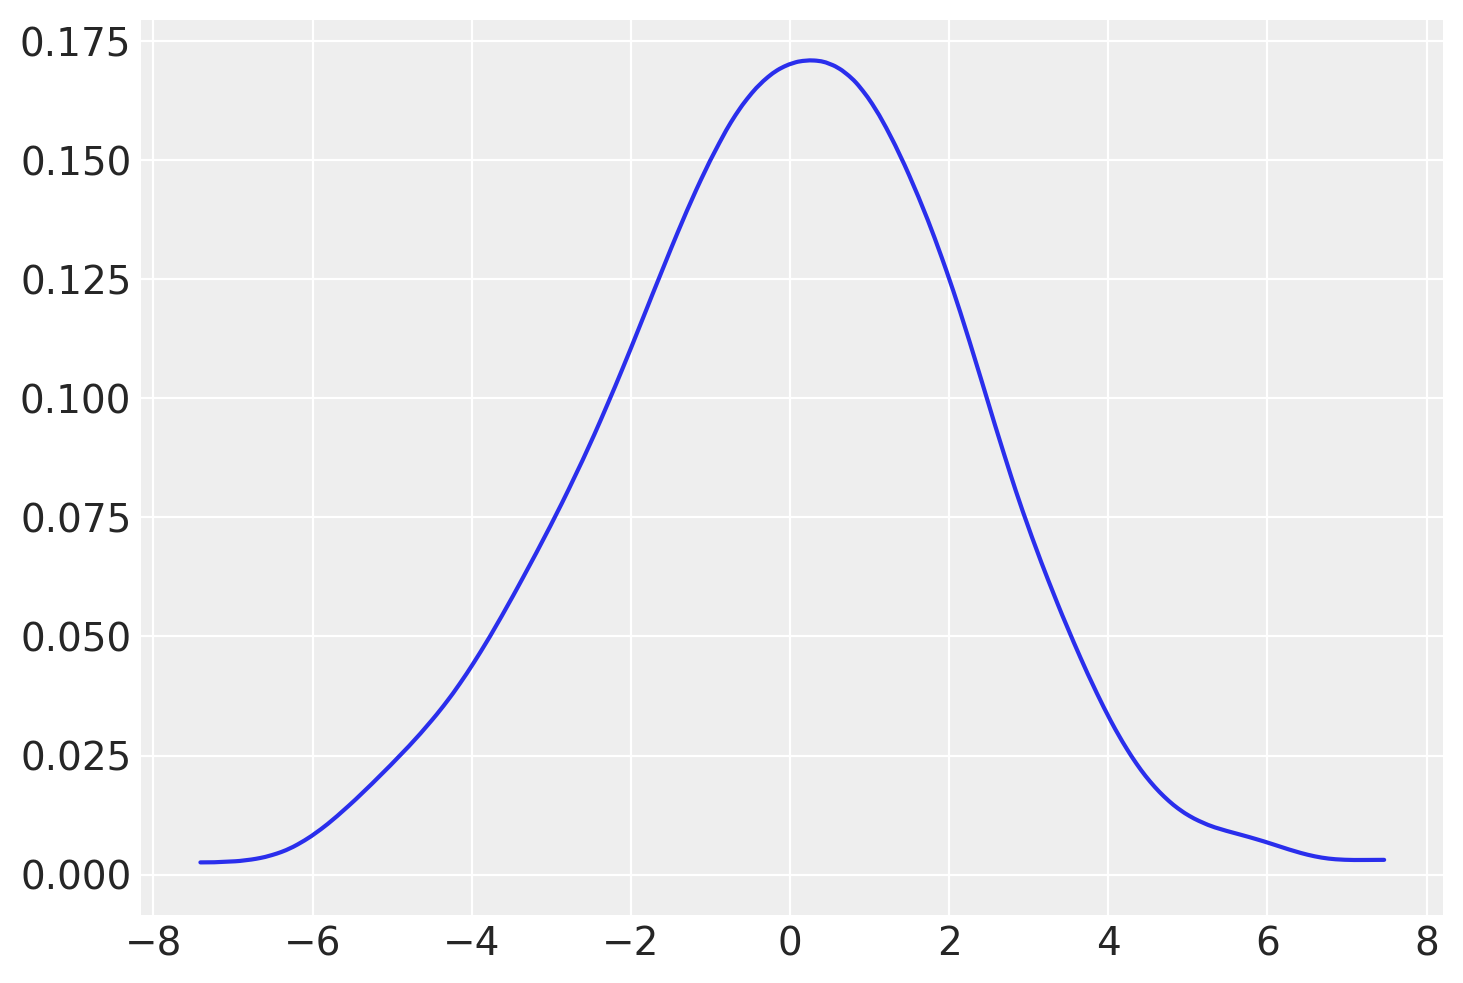

In [3]:
pos = np.random.uniform(-1, 1, size=(16, 1000)).sum(0)
az.plot_kde(pos);

#### Code 4.2 and 4.3

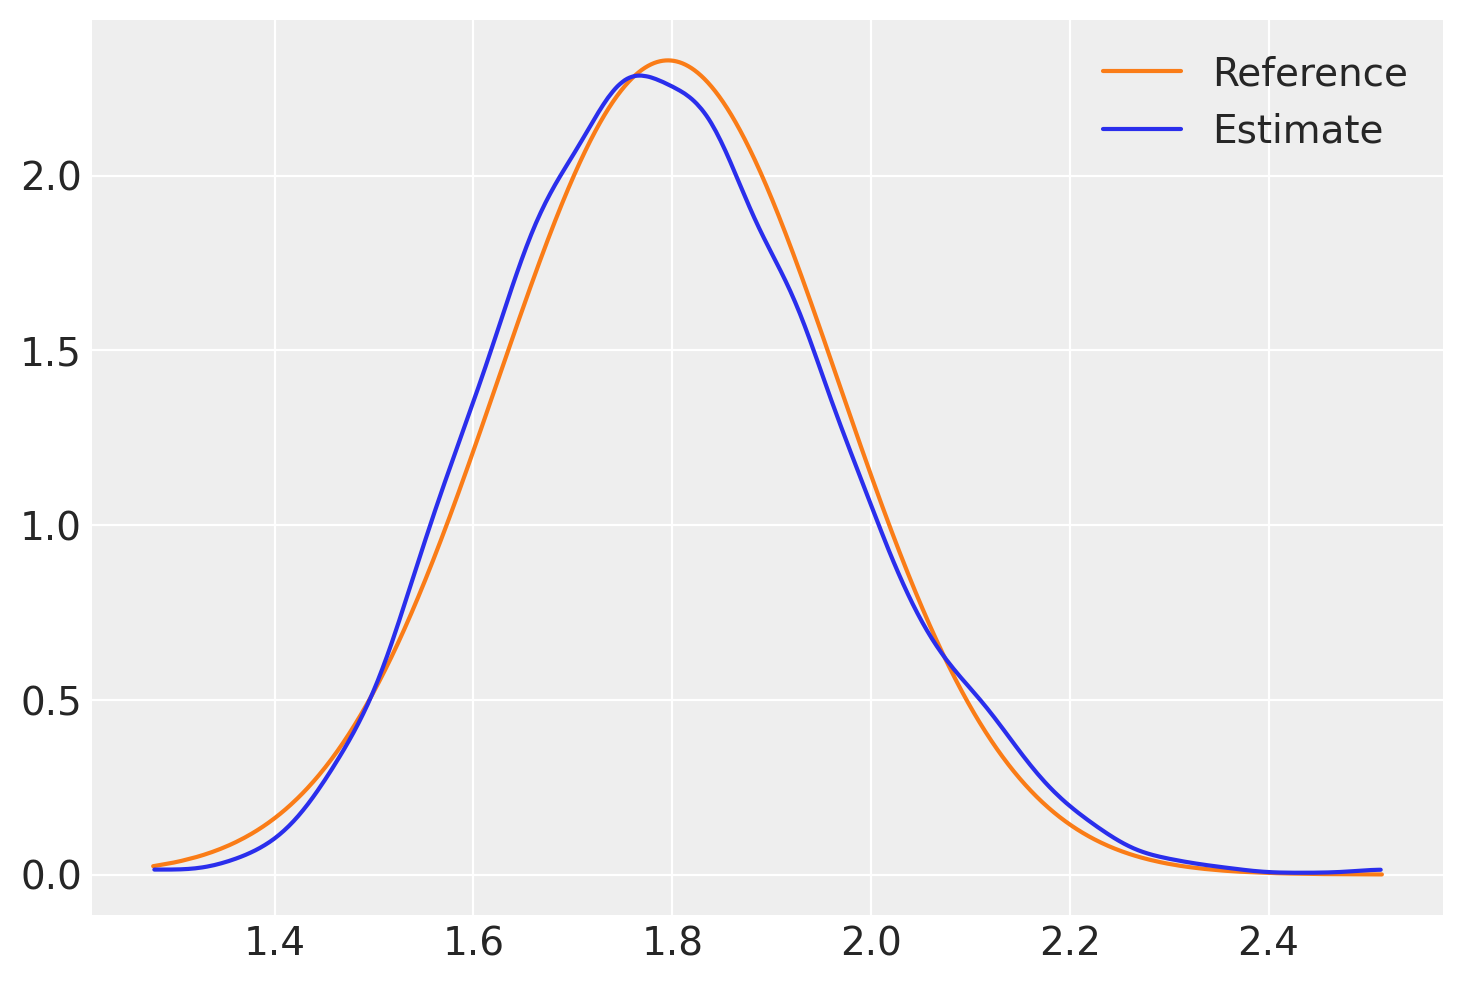

In [4]:
pos = np.random.uniform(1, 1.1, size=(12, 10000)).prod(0)
pos_sorted = np.sort(pos)
reference_normal_pdf = stats.norm.pdf(x=pos_sorted, loc=pos.mean(), scale=pos.std())
plt.plot(pos_sorted, reference_normal_pdf, color="C1", label="Reference")
az.plot_kde(pos, label="Estimate")
plt.legend(loc=0);

#### Code 4.4

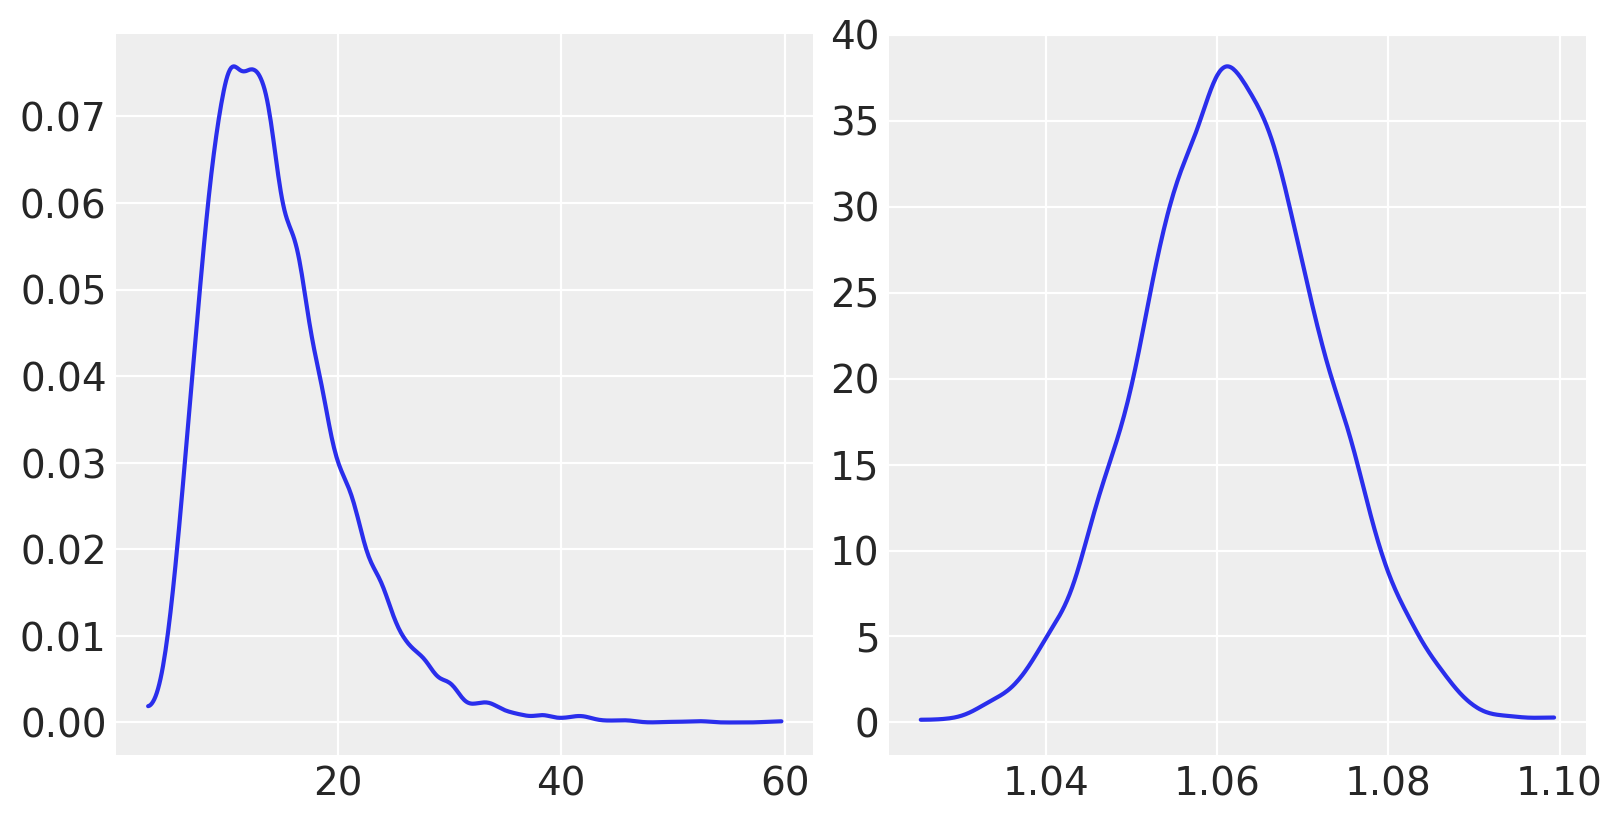

In [5]:
big = np.random.uniform(1, 1.5, size=(12, 10000)).prod(0)
small = np.random.uniform(1, 1.01, size=(12, 10000)).prod(0)
_, ax = plt.subplots(1,2, figsize=(8,4))
az.plot_kde(big, ax=ax[0])
az.plot_kde(small, ax=ax[1]);

#### Code 4.5

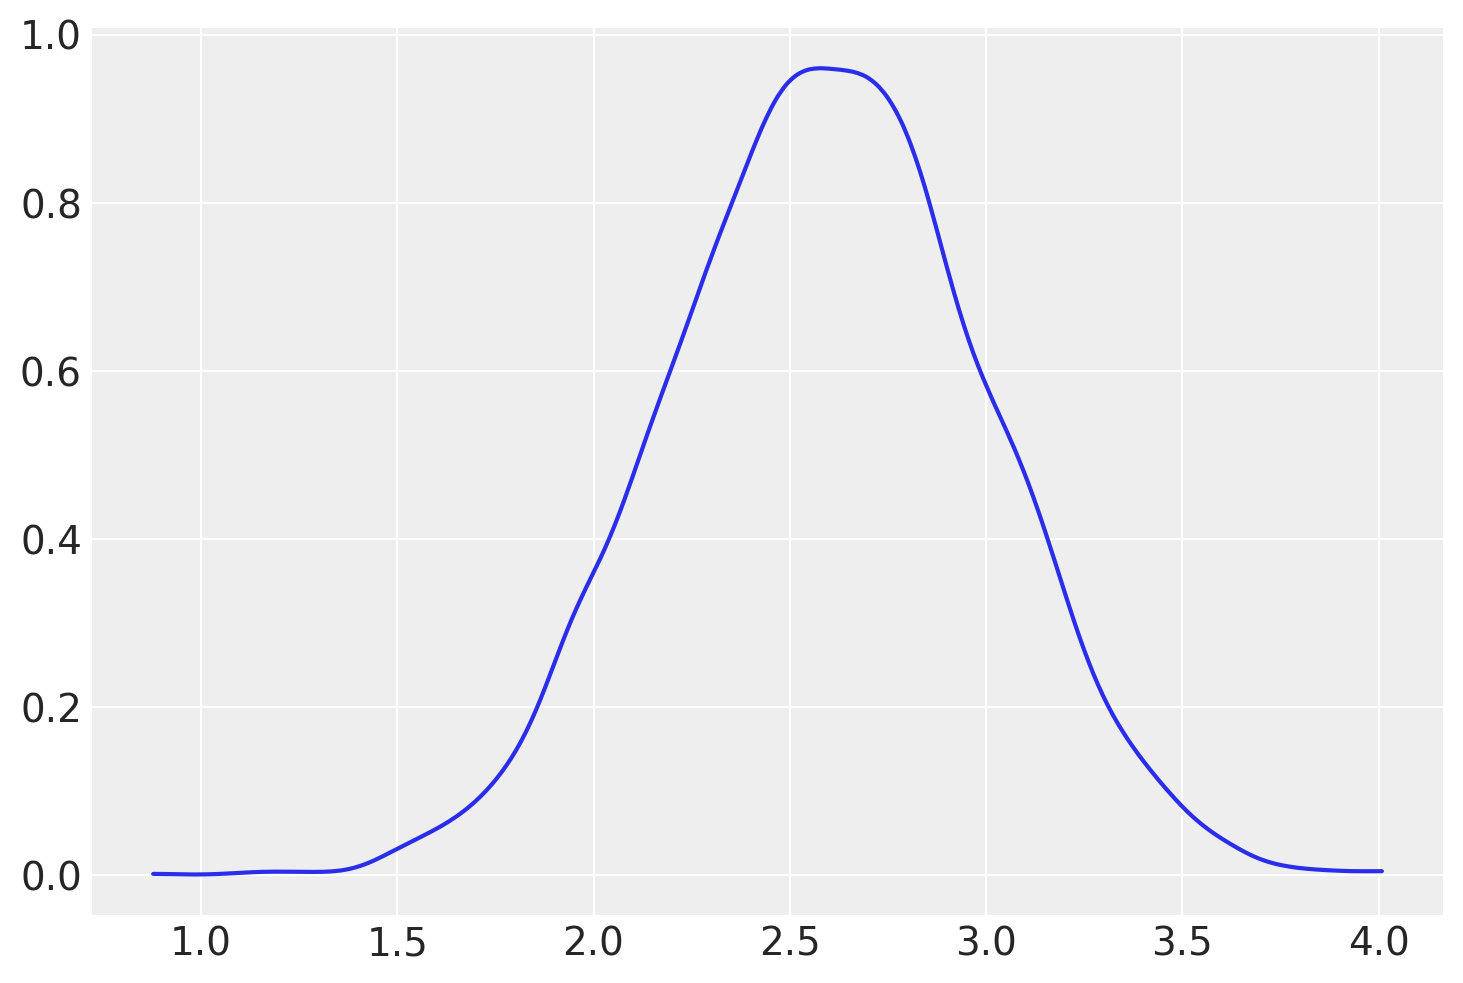

In [6]:
log_big = np.log(np.random.uniform(1, 1.5, size=(12, 10000)).prod(0))
az.plot_kde(log_big);

#### Code 4.6

We are going to use the same function we use on chapter 2 (code 2.3)

In [7]:
def posterior_grid_approx(grid_points=100, success=6, tosses=9):
    """
    """
    # define grid
    p_grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = np.repeat(5, grid_points)  # uniform
    # prior = (p_grid >= 0.5).astype(int)  # truncated
    # prior = np.exp(- 5 * abs(p_grid - 0.5))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

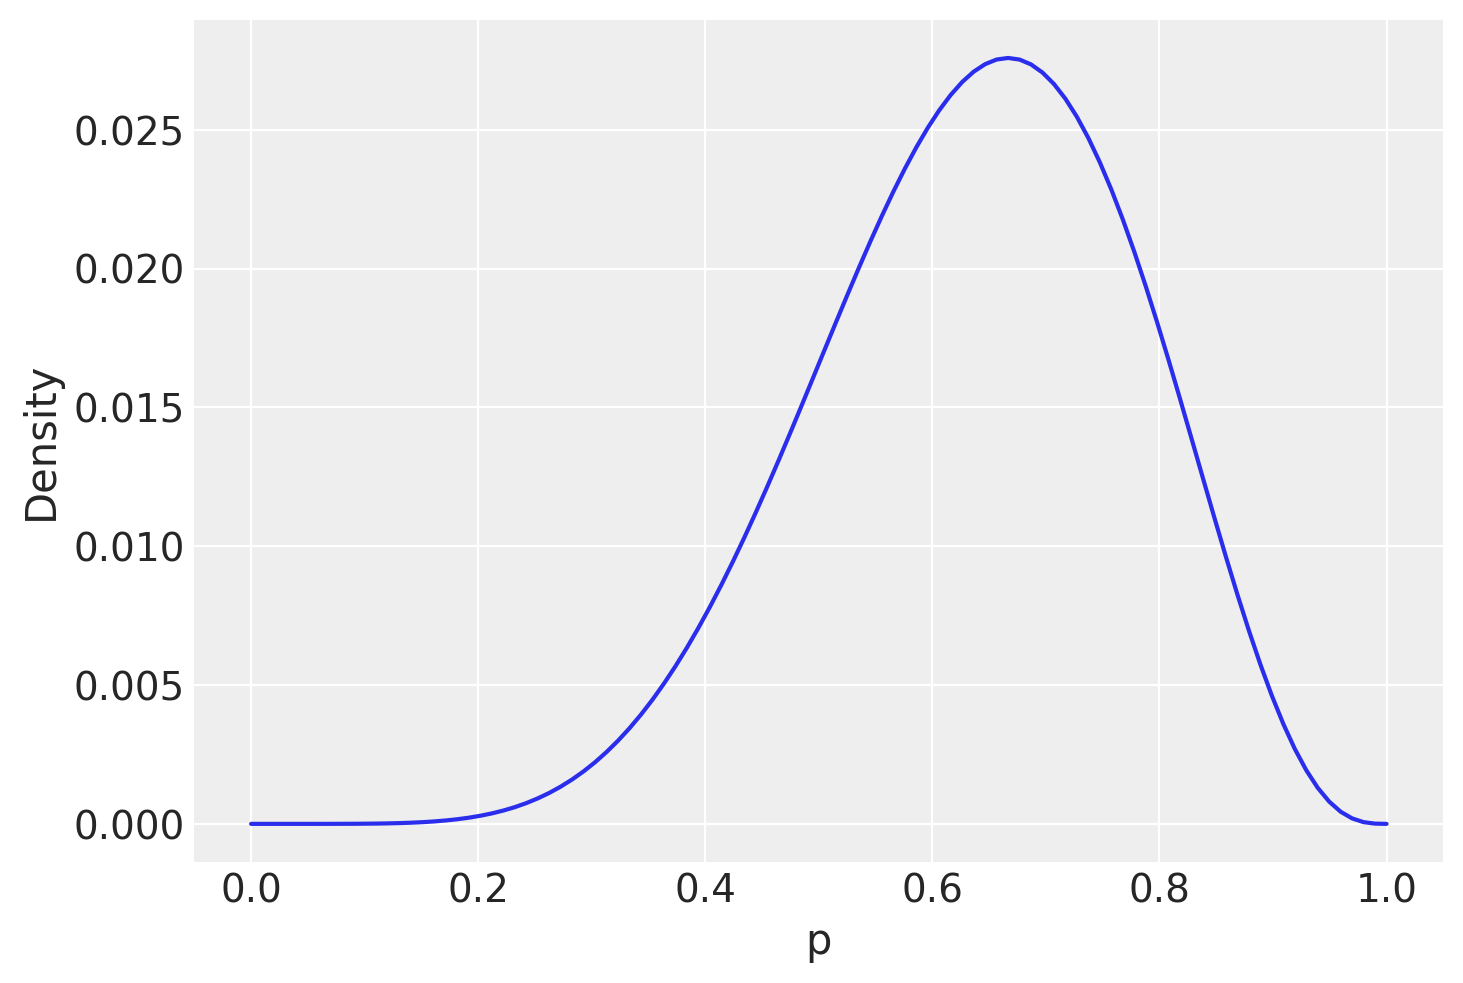

In [8]:
p_grid, posterior = posterior_grid_approx(grid_points=100, success=6, tosses=9)
plt.plot(p_grid, posterior)
plt.xlabel('p')
plt.ylabel('Density');

#### Code 4.7 and 4.8

Datasets are located in the 'data' folder.

In [9]:
d = pd.read_csv('data/Howell1.csv')
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   height  544 non-null    float64
 1   weight  544 non-null    float64
 2   age     544 non-null    float64
 3   male    544 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


#### Code 4.9

In [10]:
d.describe(percentiles=[0.055, 0.945], )

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
5.5%,81.108550,9.360721,1.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
94.5%,165.735000,54.502894,66.135000,1.000000
max,179.070000,62.992589,88.000000,1.000000


#### Code 4.10

In [11]:
d.height # or d['height']

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

#### Code 4.11

In [12]:
d2 = d[d.age >= 18]

#### Code 4.12

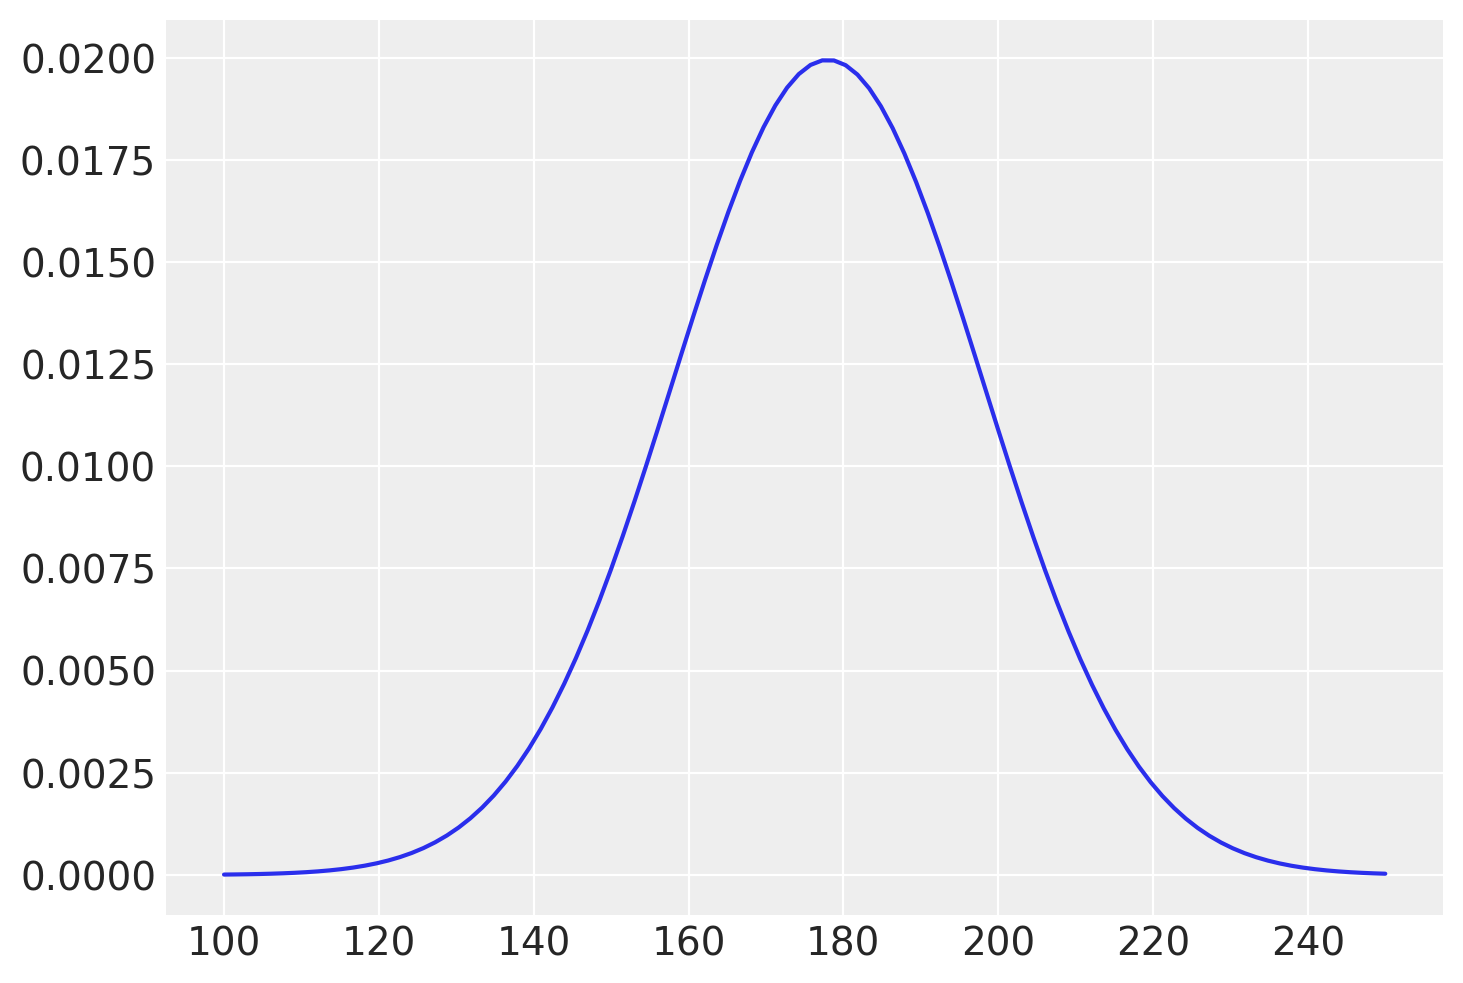

In [13]:
x = np.linspace(100, 250, 100)
plt.plot(x, stats.norm.pdf(x, 178, 20));

#### Code 4.13

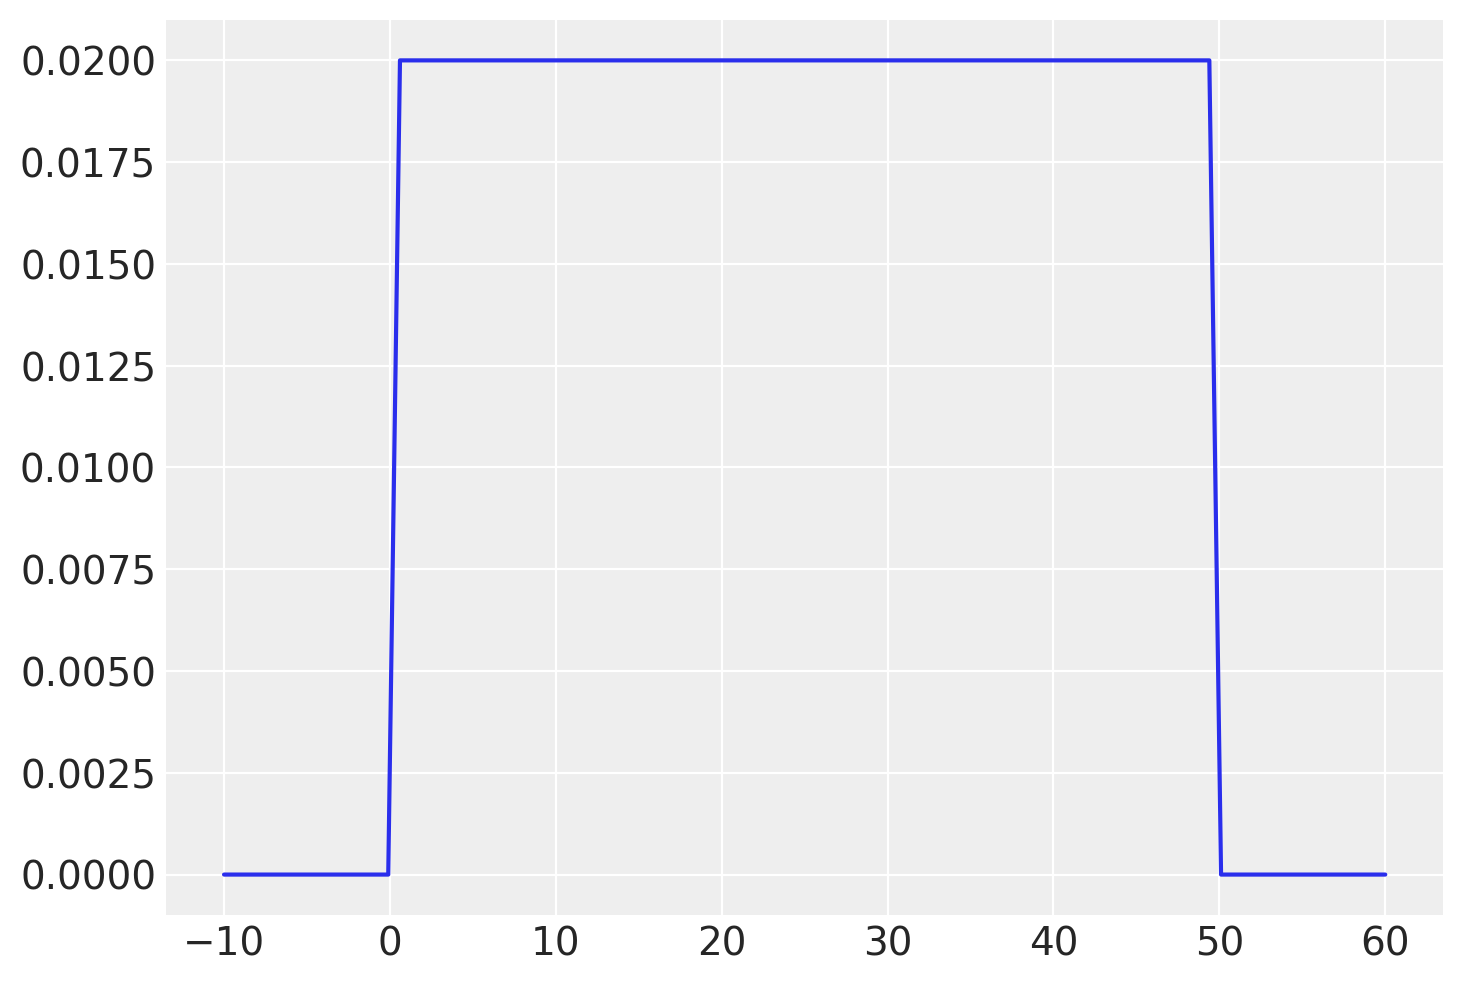

In [14]:
x = np.linspace(-10, 60, 100)
plt.plot(x, stats.uniform.pdf(x, 0, 50));

#### Code 4.14

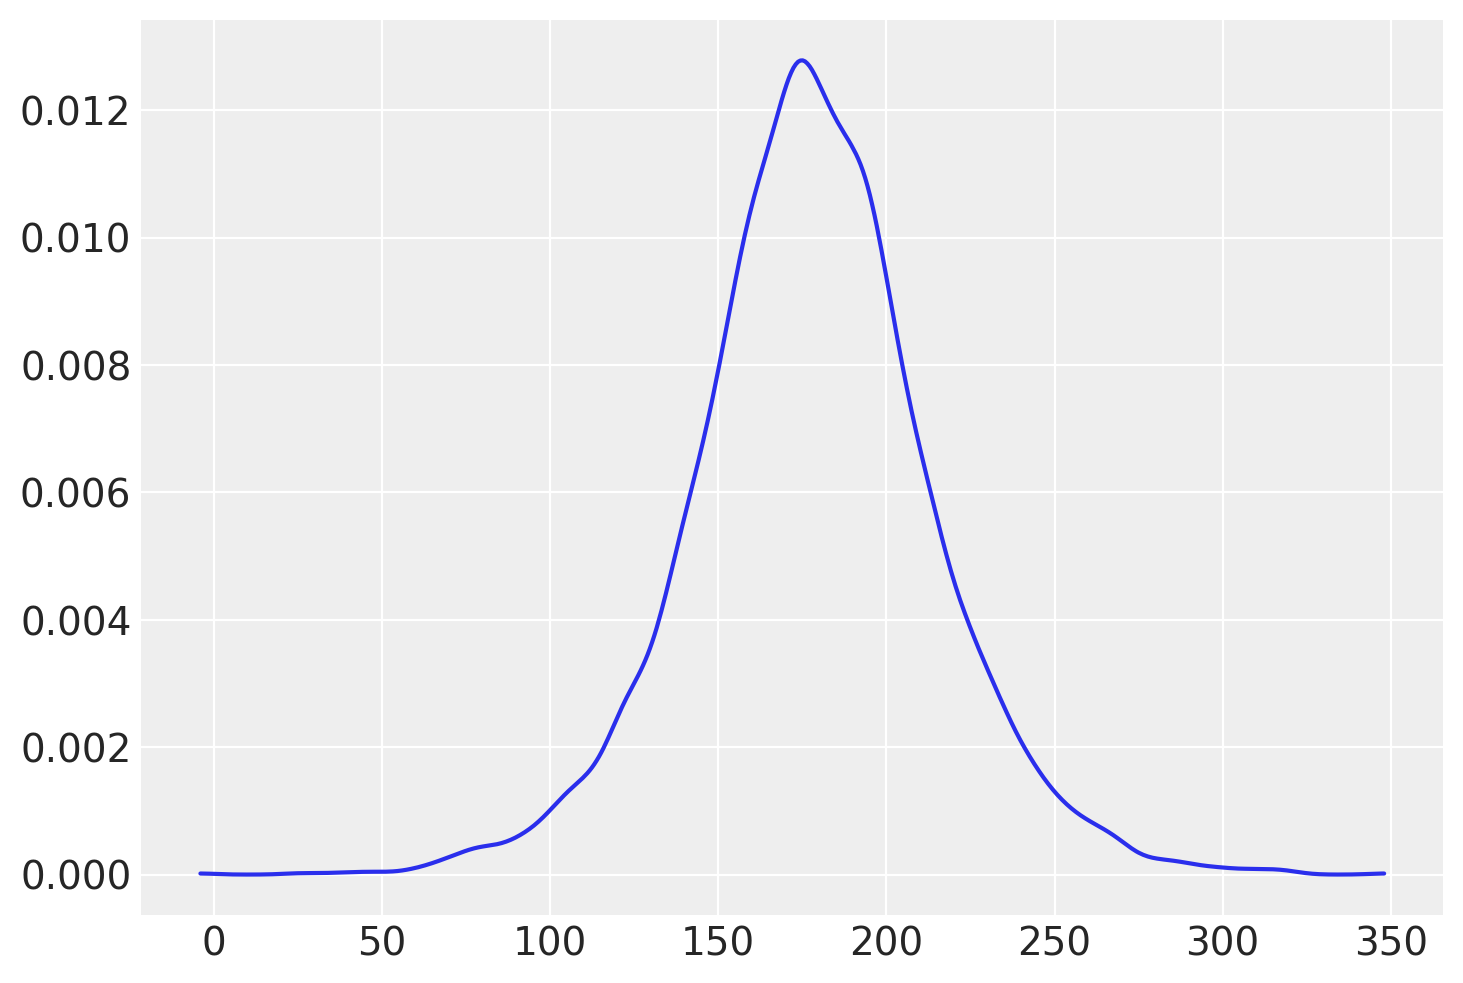

In [15]:
n = int(1e4)
sample_mu = stats.norm.rvs(178, 20, size=n)
sample_sigma = stats.uniform.rvs(0, 50, size=n)
prior_h = stats.norm.rvs(sample_mu, sample_sigma) # size is not required

az.plot_kde(prior_h);

#### Code 4.15

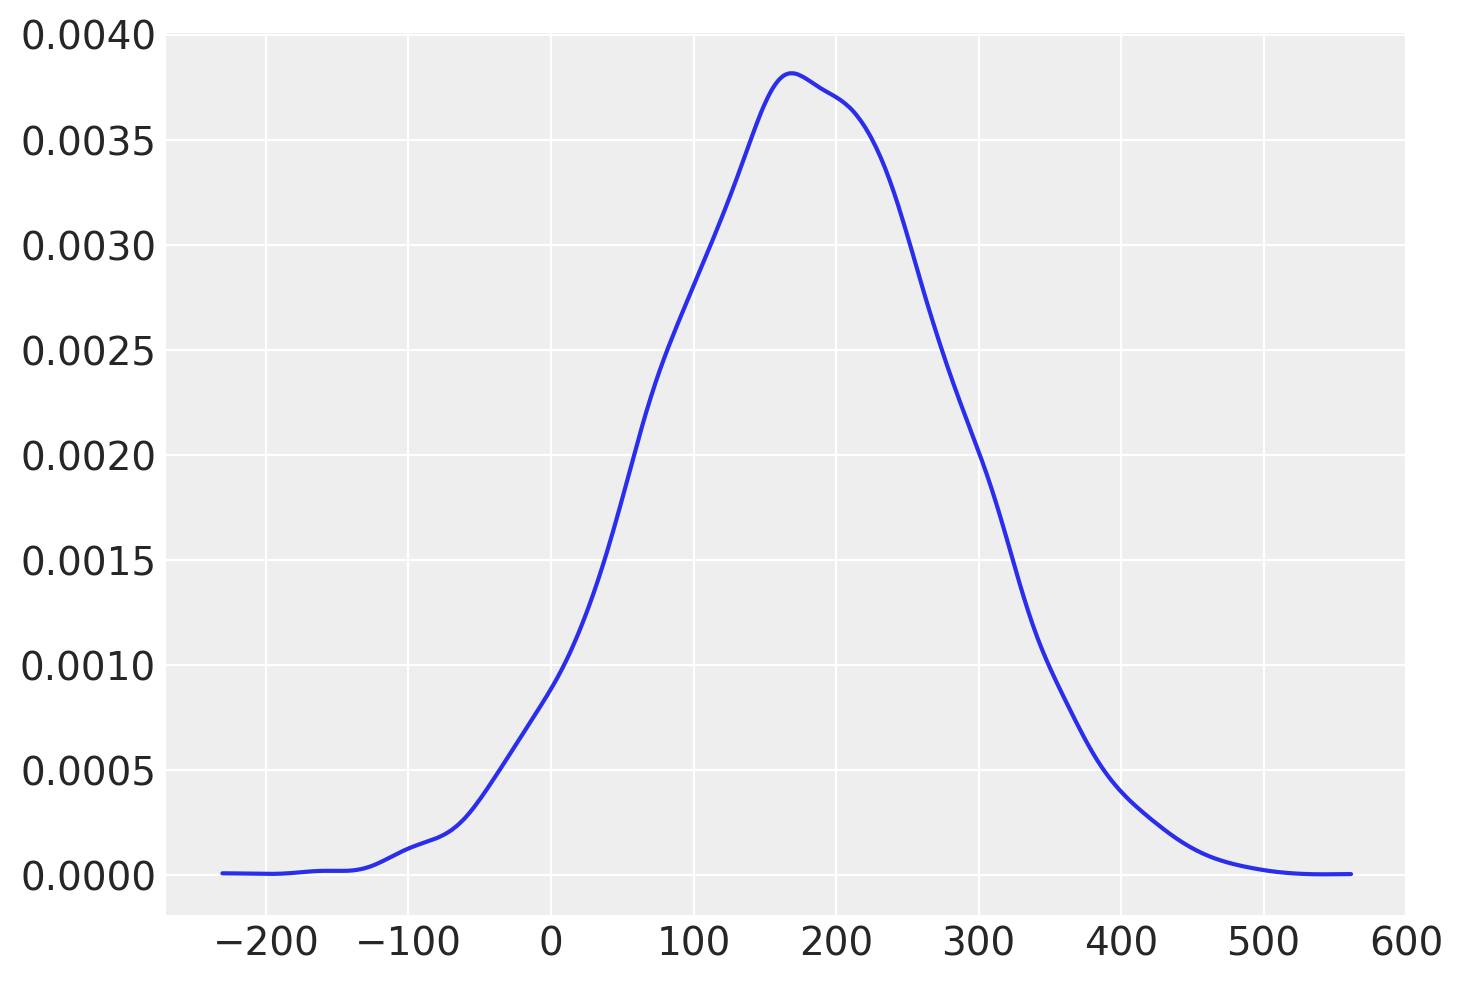

In [16]:
n = int(1e4)
sample_mu = stats.norm.rvs(178, 100, size=n)
prior_h = stats.norm.rvs(sample_mu, sample_sigma)
az.plot_kde(prior_h);

#### Code 4.16

In [17]:
mu_list = np.linspace(150, 160, num=100)
sigma_list = np.linspace(7, 9, num=100)
post = pd.DataFrame(np.array(np.meshgrid(mu_list, sigma_list)).reshape(2,-1).T, columns=["mu", "sigma"])
post['LL'] = [
    stats.norm.logpdf(d2.height, loc=post.mu[i], scale=post.sigma[i]).sum() 
    for i in post.index
]
post['prod'] = post.LL + stats.norm.logpdf(post.mu, loc=178, scale=20) + stats.uniform.logpdf(post.sigma, 0, 50)
post['prob'] = np.exp(post['prod'] - post['prod'].max())

#### Code 4.17

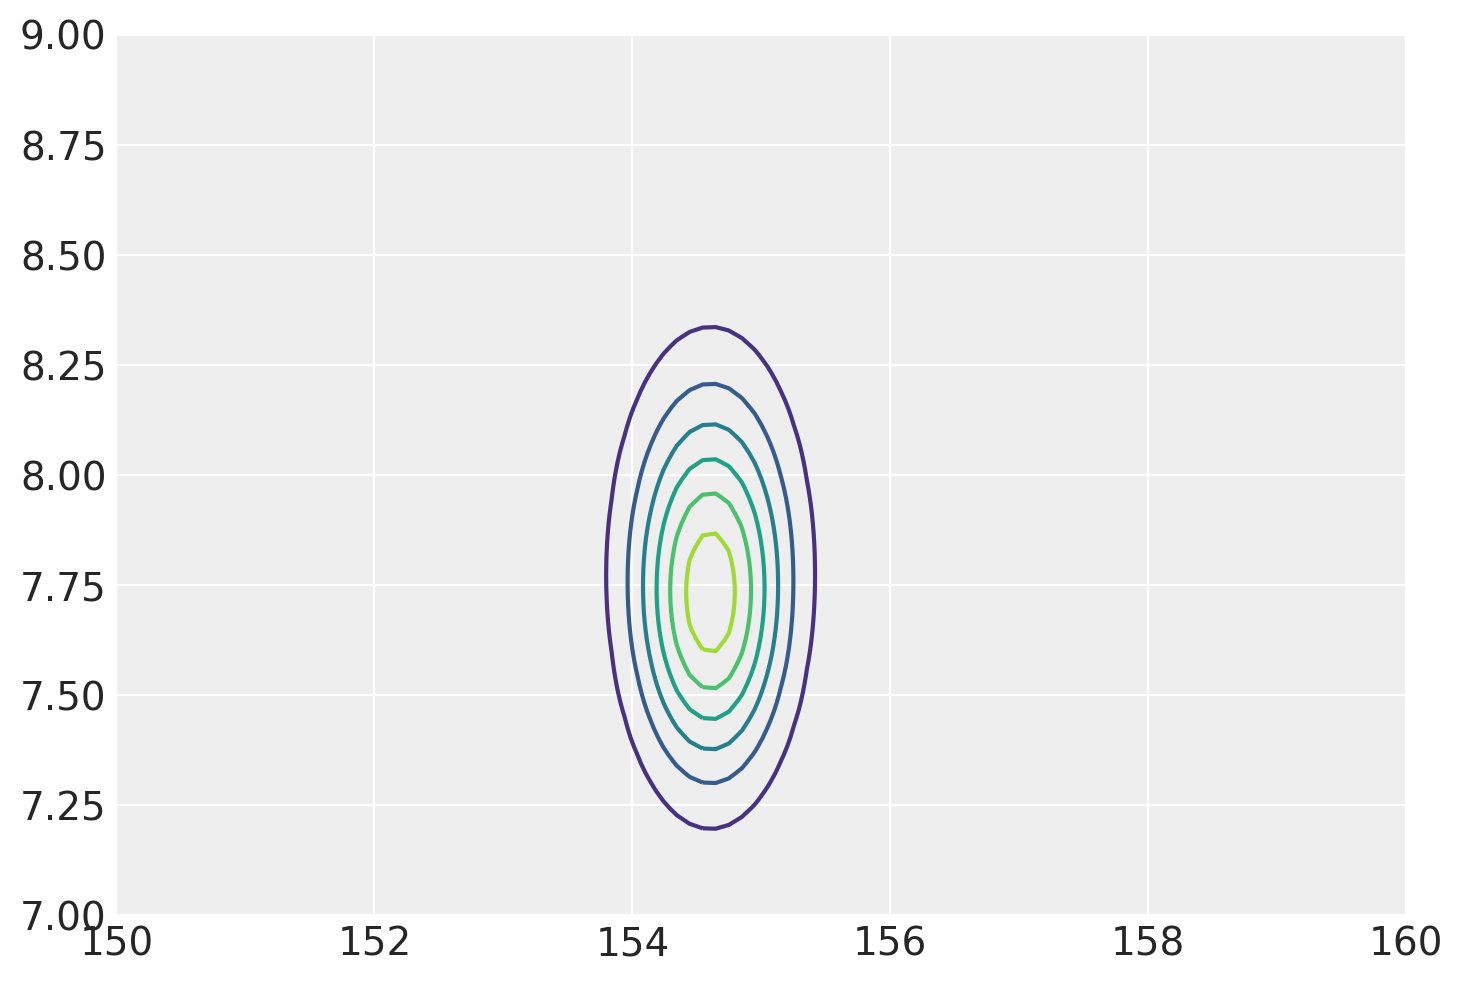

In [18]:
xi = np.linspace(post['mu'].min(), post['mu'].max(), 100)
yi = np.linspace(post['sigma'].min(), post['sigma'].max(), 100)
zi = griddata((post['mu'], post['sigma']), post['prob'] , (xi[None,:], yi[:,None]))

plt.contour(xi, yi, zi);

#### Code 4.18

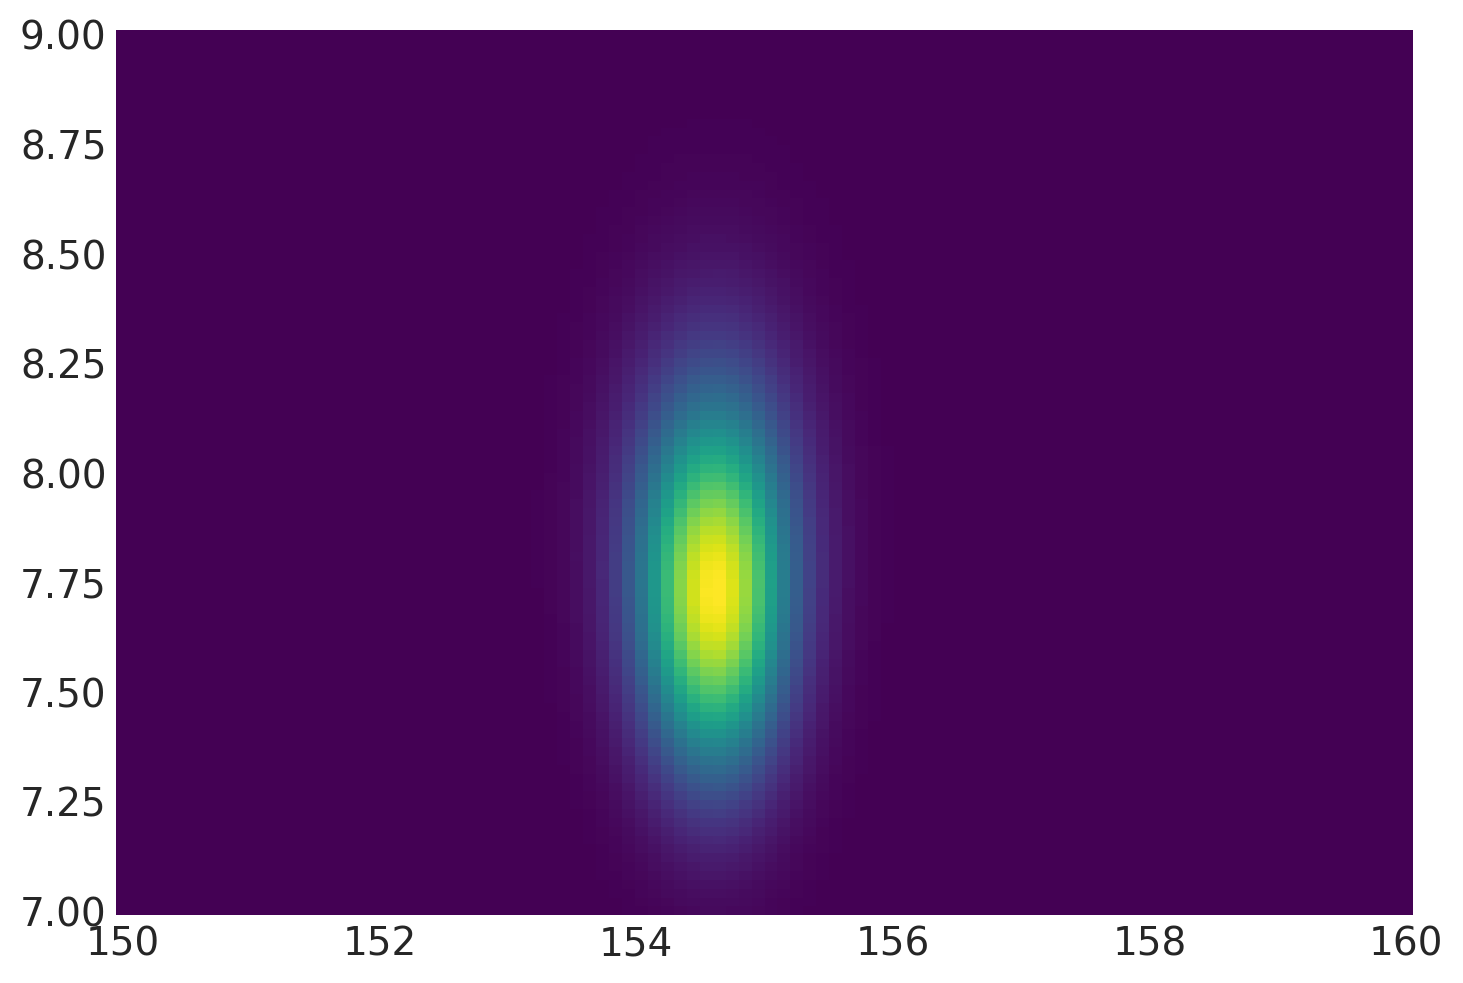

In [19]:
plt.pcolormesh(xi, yi, zi, shading='auto');

#### Code 4.19

In [20]:
sample_rows = np.random.choice(post.index, size=int(1e4), replace=True, p = post['prob'] / post['prob'].sum())
sample_mu = post.mu[sample_rows]
sample_sigma = post.sigma[sample_rows]

#### Code 4.20

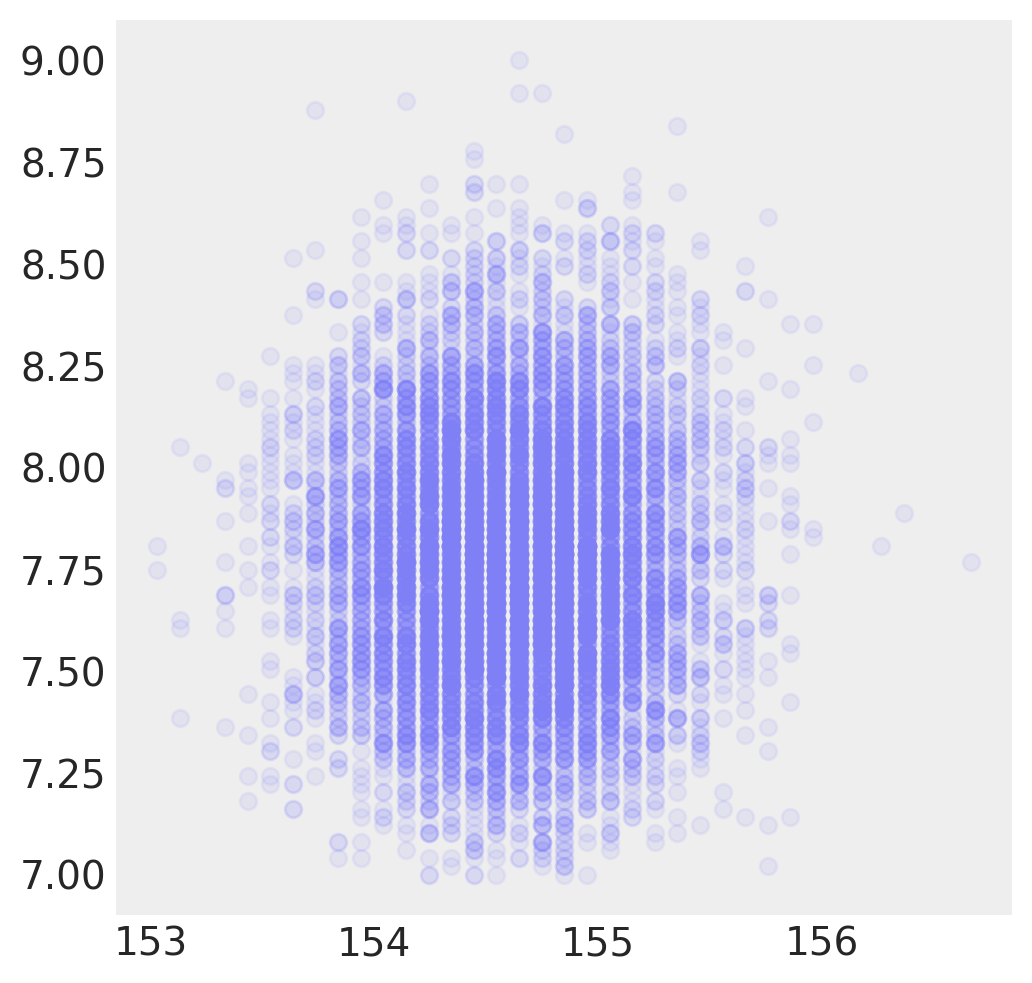

In [21]:
fig, ax = plt.subplots()
ax.set_box_aspect(1)
ax.plot(sample_mu, sample_sigma, 'o', color="#8080FF", alpha=0.1)
ax.grid(False);

#### Code 4.21

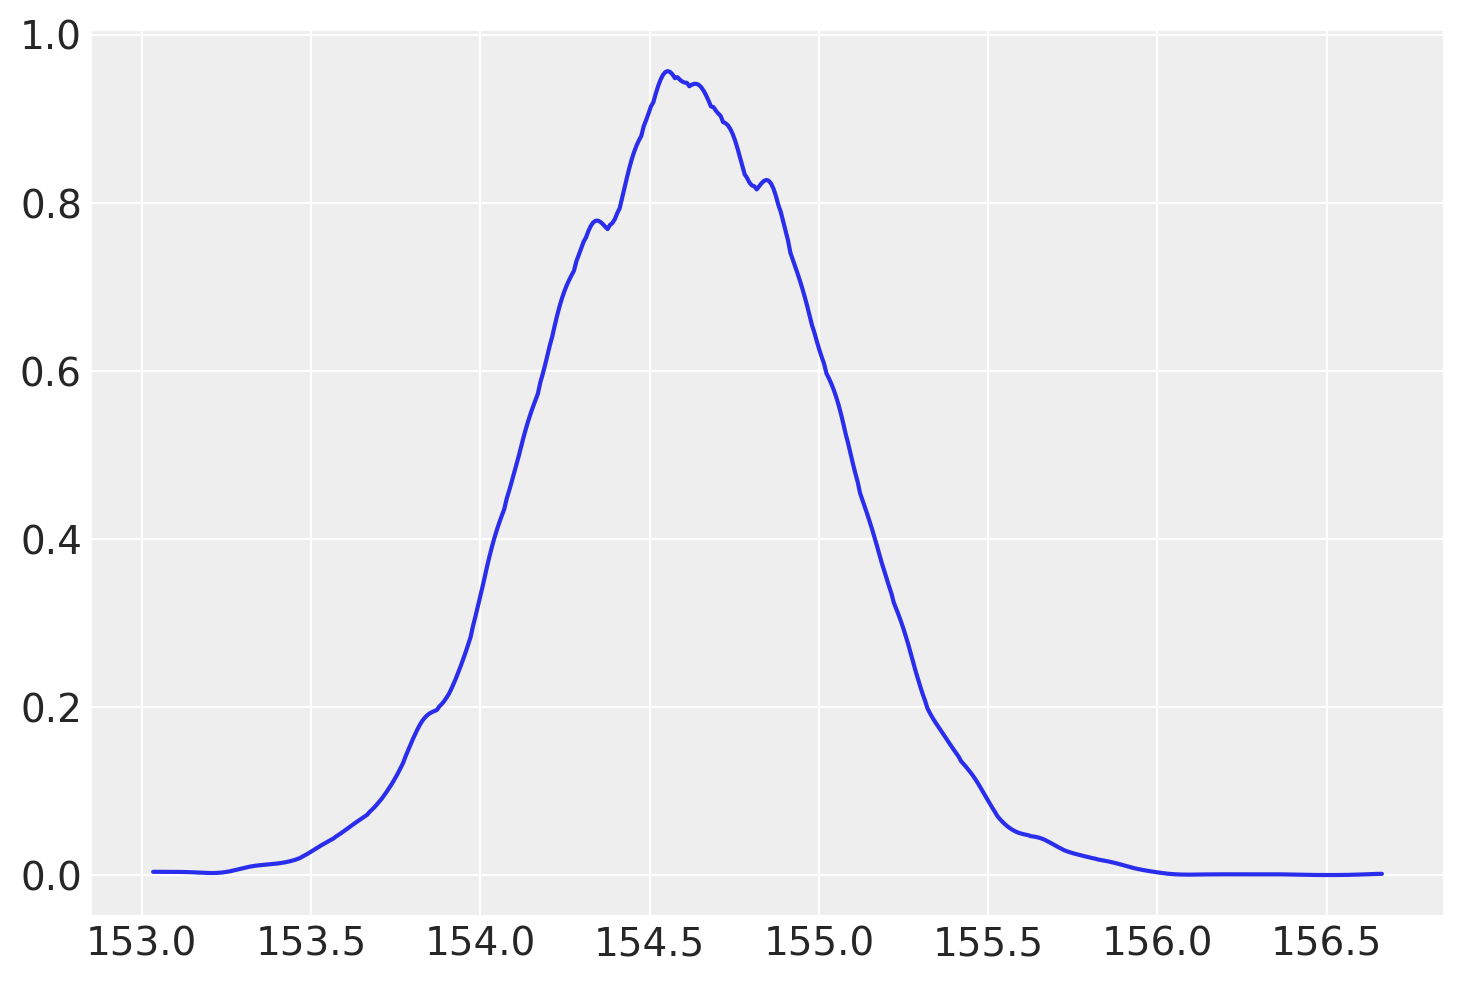

In [22]:
az.plot_kde(sample_mu, bw="silverman");

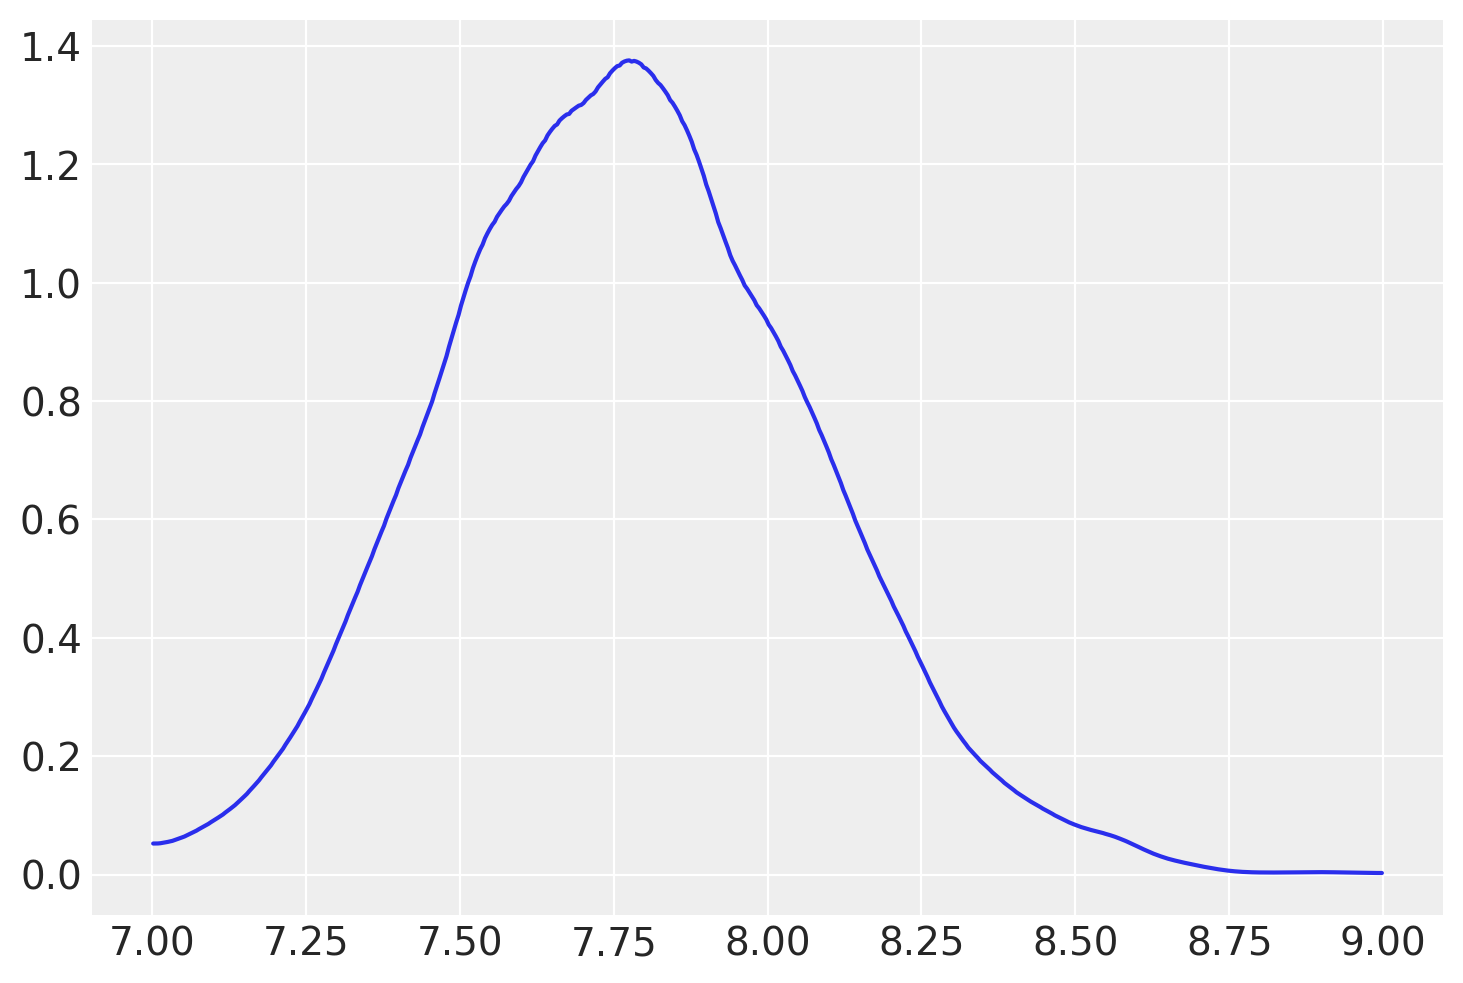

In [23]:
az.plot_kde(sample_sigma, bw="silverman");

#### Code 4.22

In [24]:
np.quantile(sample_mu, q=[0.04, 0.95])

array([153.83838384, 155.25252525])

In [25]:
np.quantile(sample_sigma, q=[0.04, 0.95])

array([7.28282828, 8.25353535])

#### Code 4.23

In [26]:
d3 = np.random.choice(d2.height, size=20)

#### Code 4.24

In [27]:
mu_list = np.linspace(150, 170, num=200)
sigma_list = np.linspace(4, 20, num=200)
post2 = pd.DataFrame(np.array(np.meshgrid(mu_list, sigma_list)).reshape(2, -1).T, columns=["mu", "sigma"])
post2['LL'] = [
    stats.norm.logpdf(d3, loc=post2.mu[i], scale=post2.sigma[i]).sum() 
    for i in post2.index
]
post2['prod'] = post2.LL + stats.norm.logpdf(post2.mu, 178, 20) + stats.uniform.logpdf(post2.sigma, 0, 50)
post2['prob'] = np.exp(post2['prod'] - post2['prod'].max())

sample2_rows = np.random.choice(post2.index, size=int(1e4), replace=True, p = post2['prob'] / post2['prob'].sum())
sample2_mu = post2.mu[sample2_rows]
sample2_sigma = post2.sigma[sample2_rows]

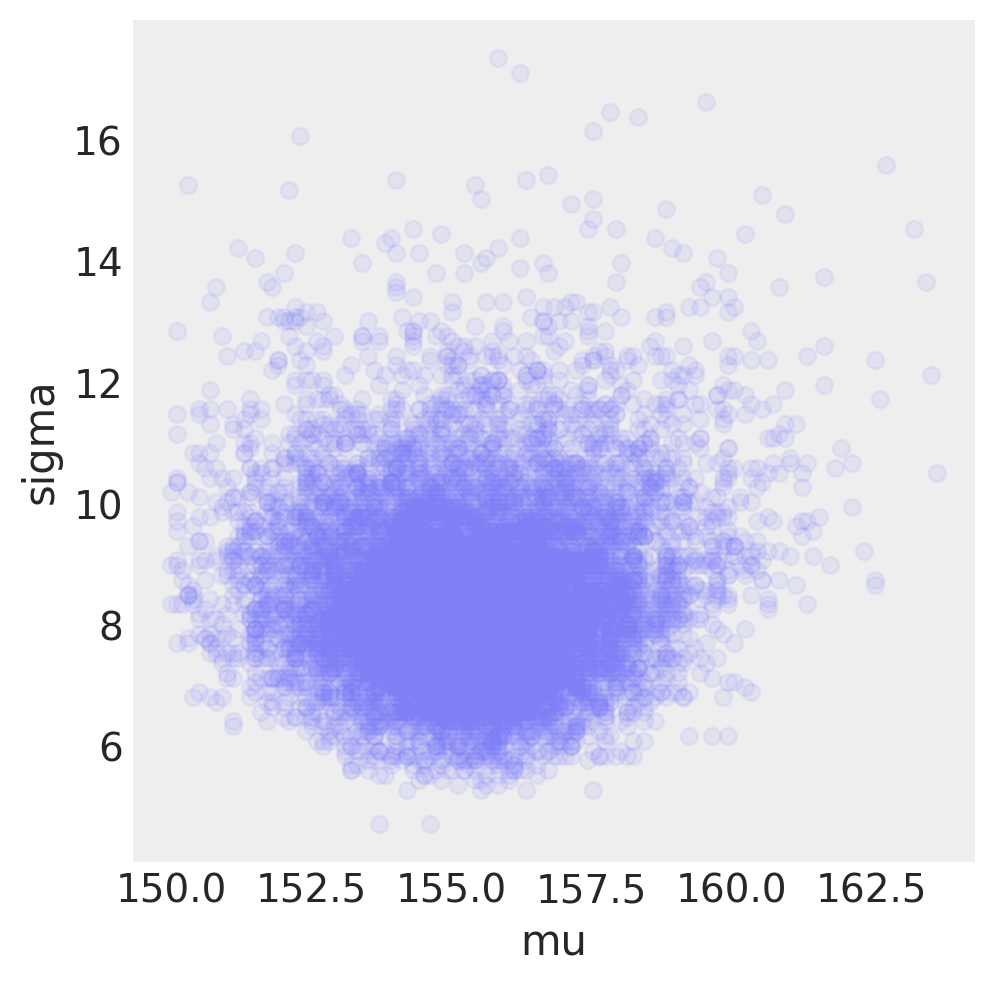

In [28]:
fig, ax = plt.subplots()
ax.set_box_aspect(1)
ax.plot(sample2_mu, sample2_sigma, 'o', color="#8080FF", alpha=0.1)
ax.set_xlabel('mu')
ax.set_ylabel('sigma')
ax.grid(False);

#### Code 4.25

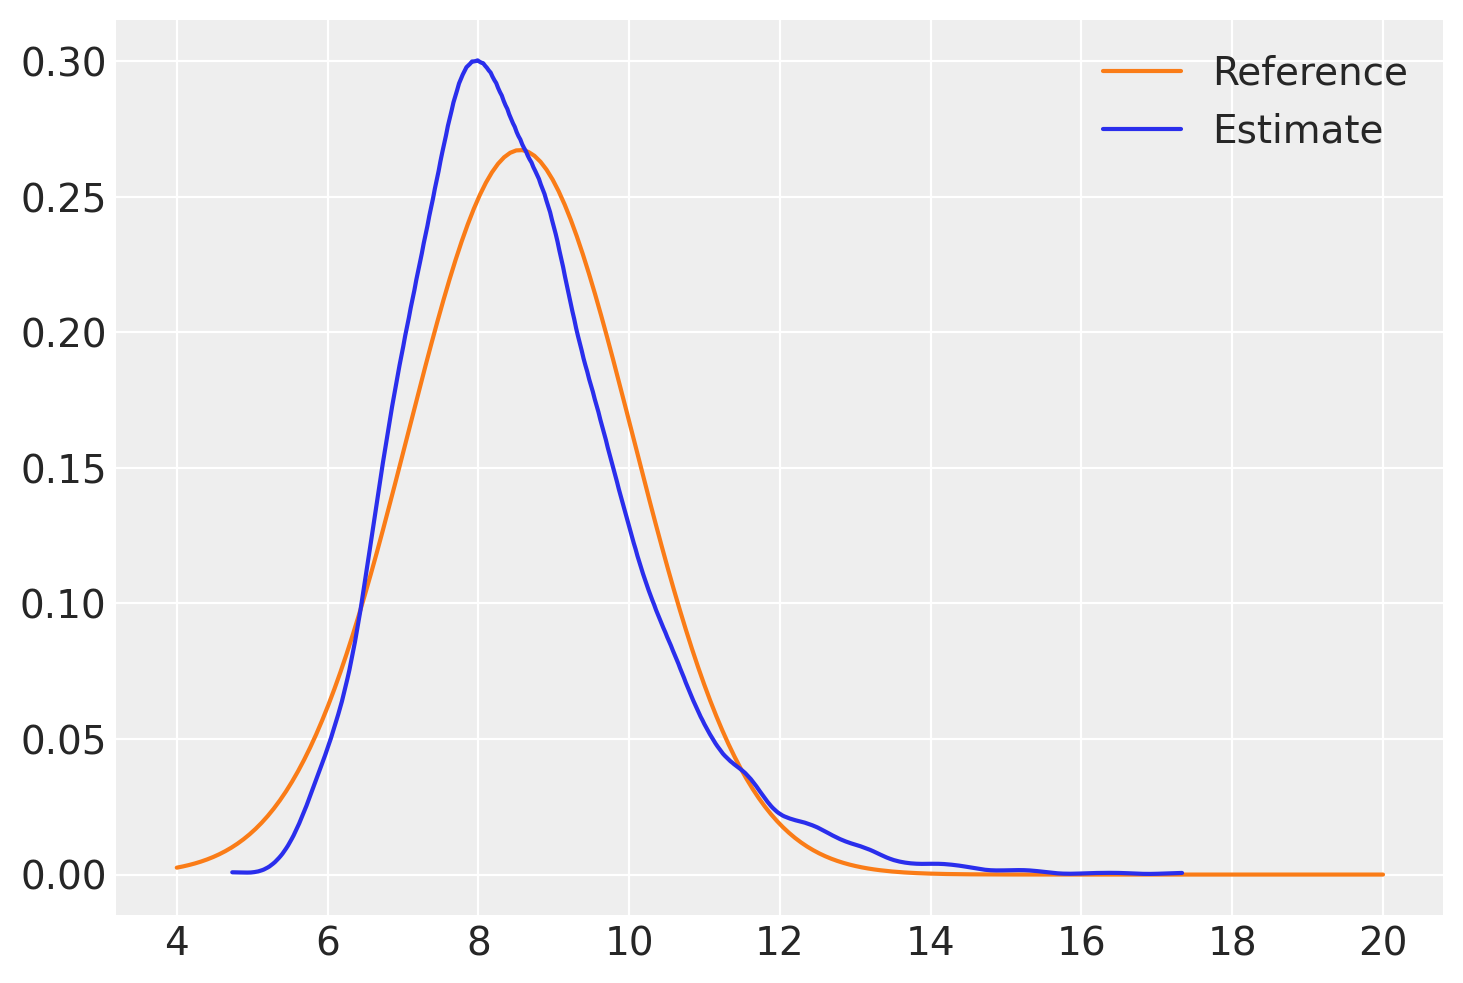

In [29]:
grid = np.linspace(4, 20, 200)
plt.plot(grid, stats.norm.pdf(grid, sample2_sigma.mean(), sample2_sigma.std()), color="C1", label="Reference")
az.plot_kde(sample2_sigma, bw="silverman", label="Estimate")
plt.legend(loc=0);

#### Code 4.26
We read the data again

In [30]:
d = pd.read_csv("data/Howell1.csv")
d2 = d[d.age >= 18]

#### Code 4.27 and 4.28

Note here we are using MCMC instead of quadratic approximation.

In [31]:
# Uniform prior for the intercept
priors = {
    'Intercept': bmb.Prior('Normal', mu=178, sd=20),
    'height_sigma': bmb.Prior('Uniform', lower=0, upper=50)
} 
model_4_1 = bmb.Model('height ~ 1', d2, priors=priors)
results_4_1 = model_4_1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [height_sigma, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


#### Code 4.29

In [32]:
az.summary(results_4_1, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,154.615,0.406,153.893,155.423
height_sigma,7.749,0.303,7.219,8.312


#### Code 4.30
Since priors don't change, we can reutilize the previous `model` object.

In [33]:
start = {
    "height": d2.height.mean(),
    "height_sigma": d2.height.std(),
}
results_4_1 = model_4_1.fit(start=start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [height_sigma, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


#### Code 4.31

In [34]:
priors = {
    'Intercept': bmb.Prior('Normal', mu=178, sd=0.1),
    'height_sigma': bmb.Prior('Uniform', lower=0, upper=50)
} 
model_4_2 = bmb.Model('height ~ 1', d2, priors=priors)
results_4_2 = model_4_2.fit(start=start)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [height_sigma, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


In [35]:
az.summary(results_4_2, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,177.866,0.097,177.690,178.044
height_sigma,24.486,0.880,22.882,26.079


#### Code 4.32
Note we are using the first model, not the last we fitted.

In [36]:
mu = results_4_1.posterior["Intercept"].values.ravel()
sigma = results_4_1.posterior["height_sigma"].values.ravel()
np.cov(mu, sigma)

array([[0.16272672, 0.0027415 ],
       [0.0027415 , 0.08946369]])

#### Code 4.33

In [37]:
np.corrcoef(mu, sigma)

array([[1.        , 0.02272139],
       [0.02272139, 1.        ]])

#### Code 4.34
We did not use the quadratic approximation, instead we use a MCMC method to sample from the posterior. Thus, we already have samples. We can inspect the posterior in the results `InferenceData` object returned.

In [38]:
results_4_1.posterior.to_dataframe().head()

Intercept  height_sigma
chain draw                          
0     0     154.696996      7.919990
      1     154.793864      7.883299
      2     154.793864      7.883299
      3     154.793864      7.883299
      4     154.652937      7.588161

#### Code 4.35
In our case, this is the same we did in the code 4.29

In [39]:
az.summary(results_4_1, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,154.616,0.403,153.845,155.342
height_sigma,7.761,0.299,7.179,8.305


#### Code 4.36

In [40]:
mean = results_4_1.posterior.to_dataframe().mean()
cov = results_4_1.posterior.to_dataframe().cov()
stats.multivariate_normal.rvs(mean=mean, cov=cov, size=10)

array([[154.34540483,   8.17620095],
       [155.32290379,   7.59578073],
       [154.33177534,   7.65118727],
       [154.44532699,   7.98414262],
       [154.98600839,   8.41416341],
       [154.36574008,   7.98249191],
       [153.91535353,   7.33089377],
       [154.32653117,   7.75794414],
       [155.17576219,   7.39733005],
       [154.56004989,   7.67965775]])

#### Code 4.37

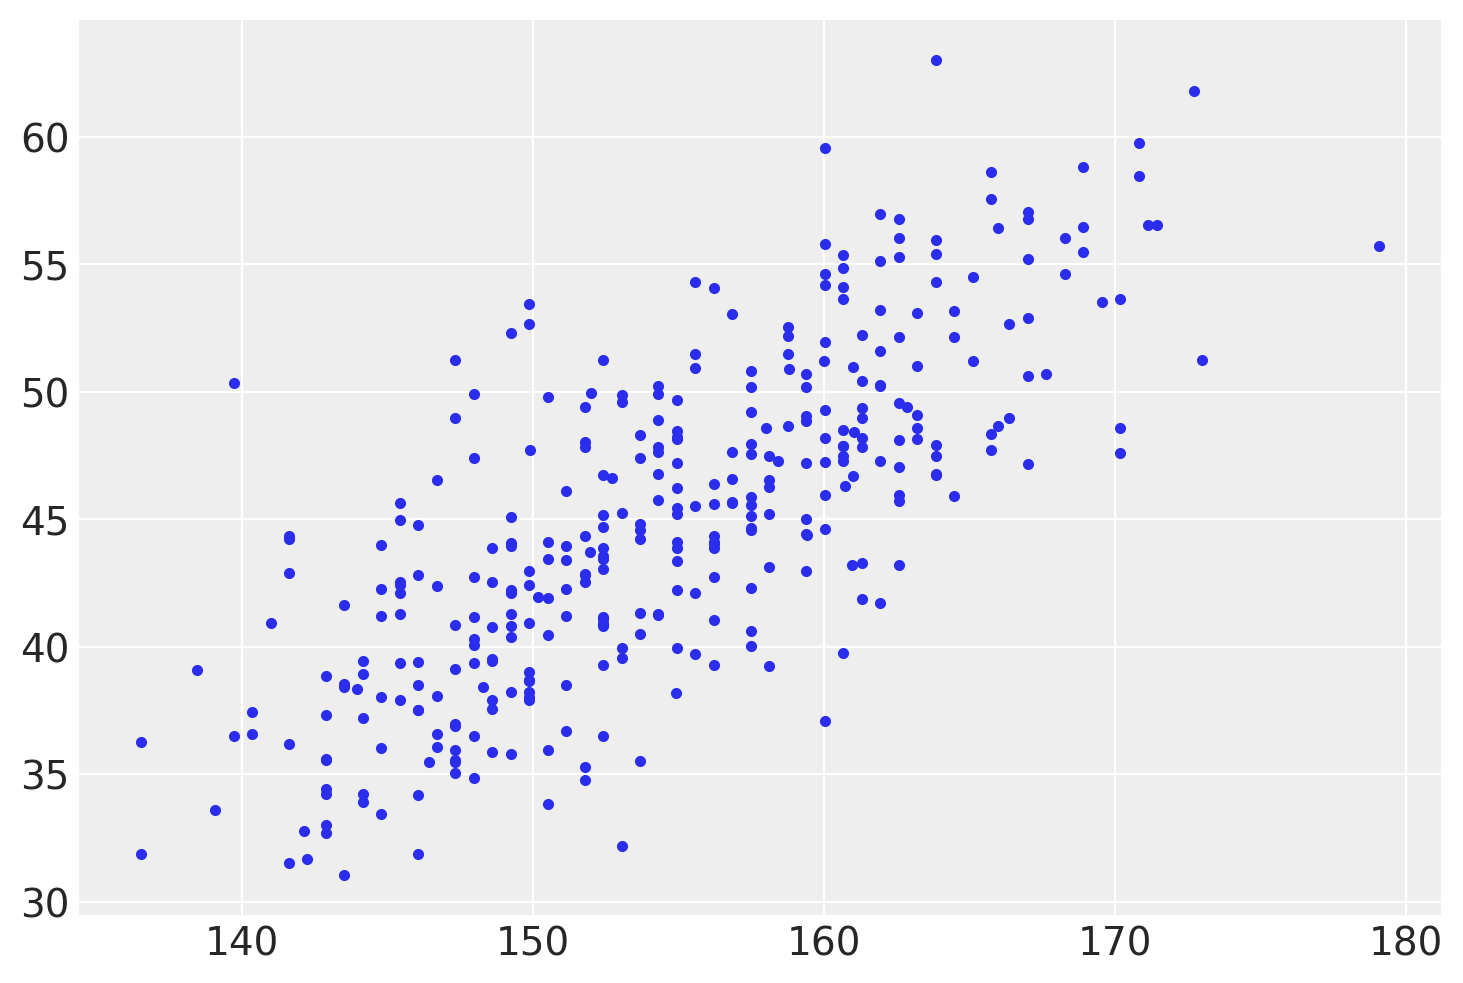

In [41]:
plt.plot(d2.height, d2.weight, ".");

#### Code 4.38

In [42]:
np.random.seed(2971)
N = 100  # 100 lines
a = stats.norm.rvs(178, 20, N)
b = stats.norm.rvs(0, 10, N)

#### Code 4.39

Here we also add the second panel of Figure 4.5

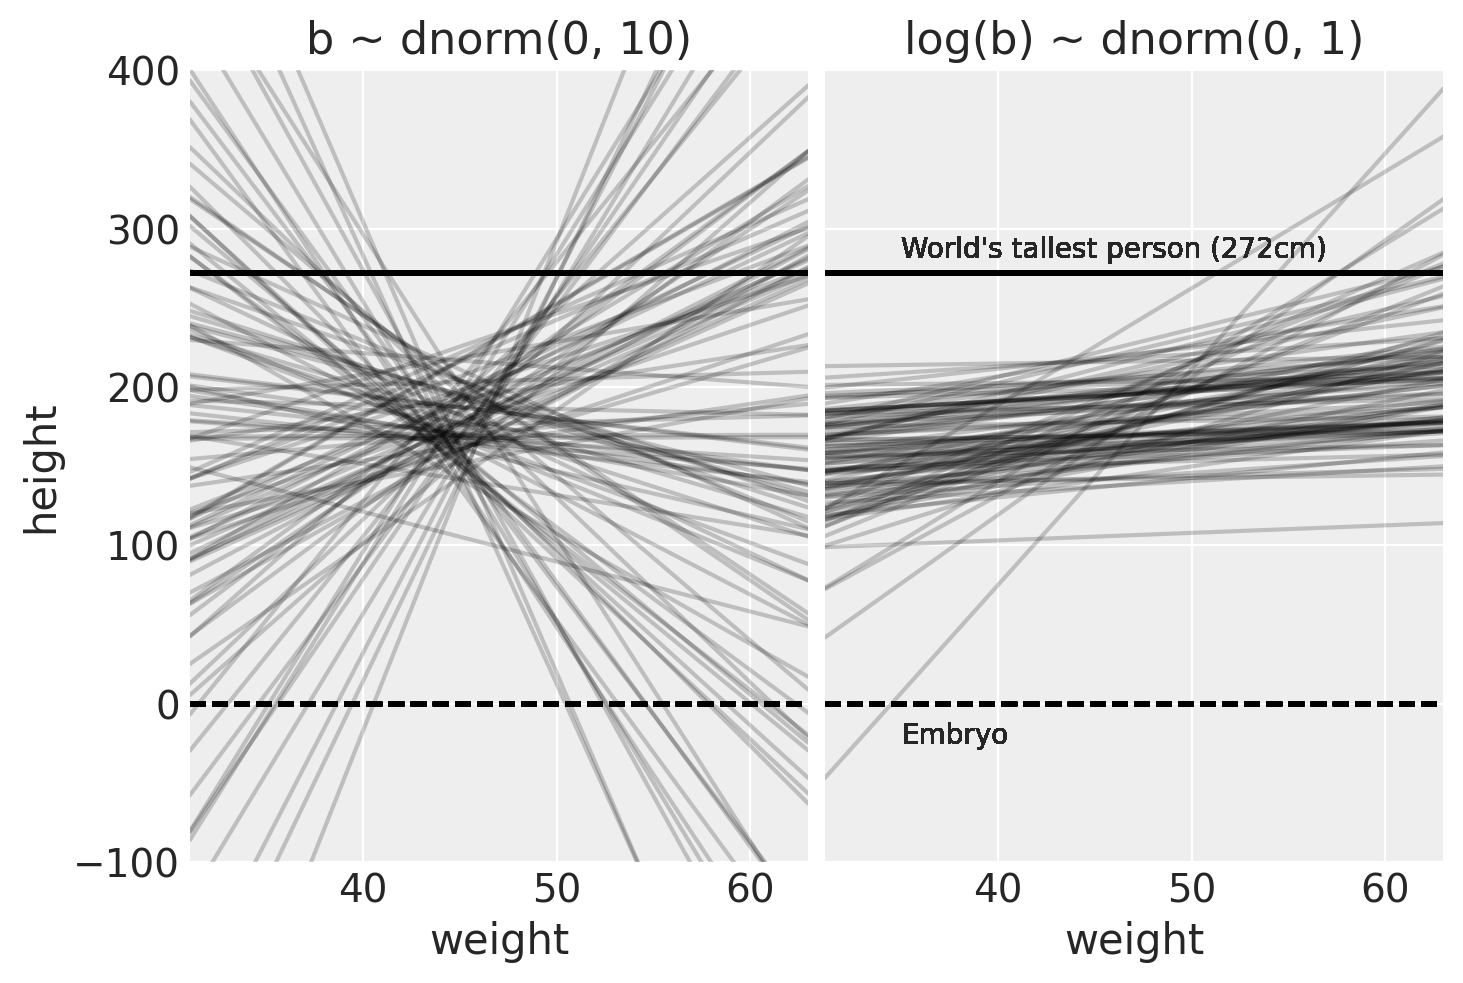

In [43]:
_, ax = plt.subplots(1, 2, sharey=True)
xbar = d2.weight.mean()
x = np.linspace(d2.weight.min(), d2.weight.max(), N)
for i in range(N):
    ax[0].plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2)
    ax[0].set_xlim(d2.weight.min(), d2.weight.max())
    ax[0].set_ylim(-100, 400)
    ax[0].axhline(0, c="k", ls="--")
    ax[0].axhline(272, c="k")
    ax[0].set_xlabel("weight")
    ax[0].set_ylabel("height")
    ax[0].set_title("b ~ dnorm(0, 10)")

b = stats.lognorm.rvs(s=1, scale=1, size=100)
for i in range(N):
    ax[1].plot(x, a[i] + b[i] * (x - xbar), "k", alpha=0.2)
    ax[1].set_xlim(d2.weight.min(), d2.weight.max())
    ax[1].set_ylim(-100, 400)
    ax[1].axhline(0, c="k", ls="--", label="embryo")
    ax[1].axhline(272, c="k")
    ax[1].set_xlabel("weight")
    ax[1].text(x=35, y=282, s="World's tallest person (272cm)")
    ax[1].text(x=35, y=-25, s="Embryo")
    ax[1].set_title("log(b) ~ dnorm(0, 1)")

#### Code 4.40

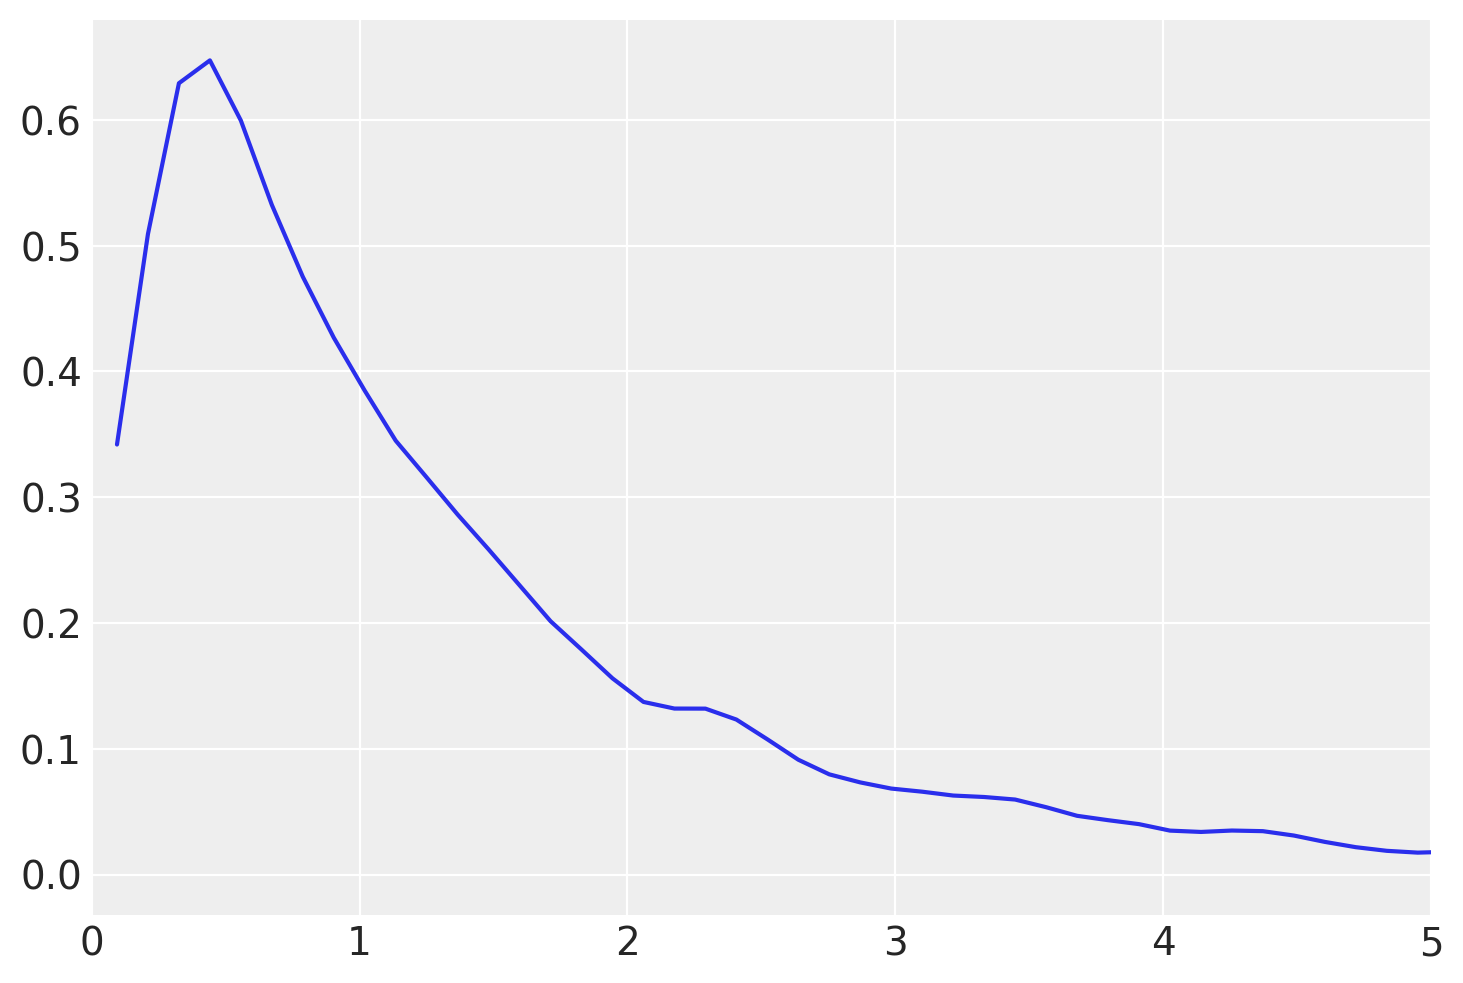

In [44]:
b = stats.lognorm.rvs(s=1, scale=1, size=int(1e4))
az.plot_kde(b)
plt.xlim((0, 5));

#### Code 4.41

Done in 4.39

#### Code 4.42

In [45]:
d = pd.read_csv("data/Howell1.csv")
d2 = d[d.age >= 18]

# define the average weight, x-bar
xbar = d2.weight.mean()

priors = {
    'Intercept': bmb.Prior('Normal', mu=178, sd=20),           # a ~ dnorm(178 ,20)
    'I(weight - xbar)': bmb.Prior('Lognormal', mu=0, sigma=1), # b ~ dlnorm(0, 1)
    'height_sigma': bmb.Prior('Uniform', lower=0, upper=50)    # sigma ~ dunif(0, 50)
}
model_4_3 = bmb.Model('height ~ I(weight - xbar)', d2, priors=priors)
results_4_3 = model_4_3.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [height_sigma, I(weight - xbar), Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


#### Code 4.43

Bambi does not allow users to insert coefficients into functions like `np.exp()`. We still need to work on it. 

#### Code 4.44

In [46]:
az.summary(results_4_3, kind="stats")

,mean,sd,hdi_3%,hdi_97%
Intercept,154.598,0.287,154.081,155.146
I(weight - xbar),0.903,0.044,0.820,0.987
height_sigma,5.105,0.194,4.736,5.427


#### Code 4.45

In [47]:
results_4_3_df = results_4_3.posterior.to_dataframe()
results_4_3_df.cov().round(3)

,Intercept,I(weight - xbar),height_sigma
Intercept,0.082,0.000,-0.001
I(weight - xbar),0.000,0.002,0.000
height_sigma,-0.001,0.000,0.038


#### Code 4.46

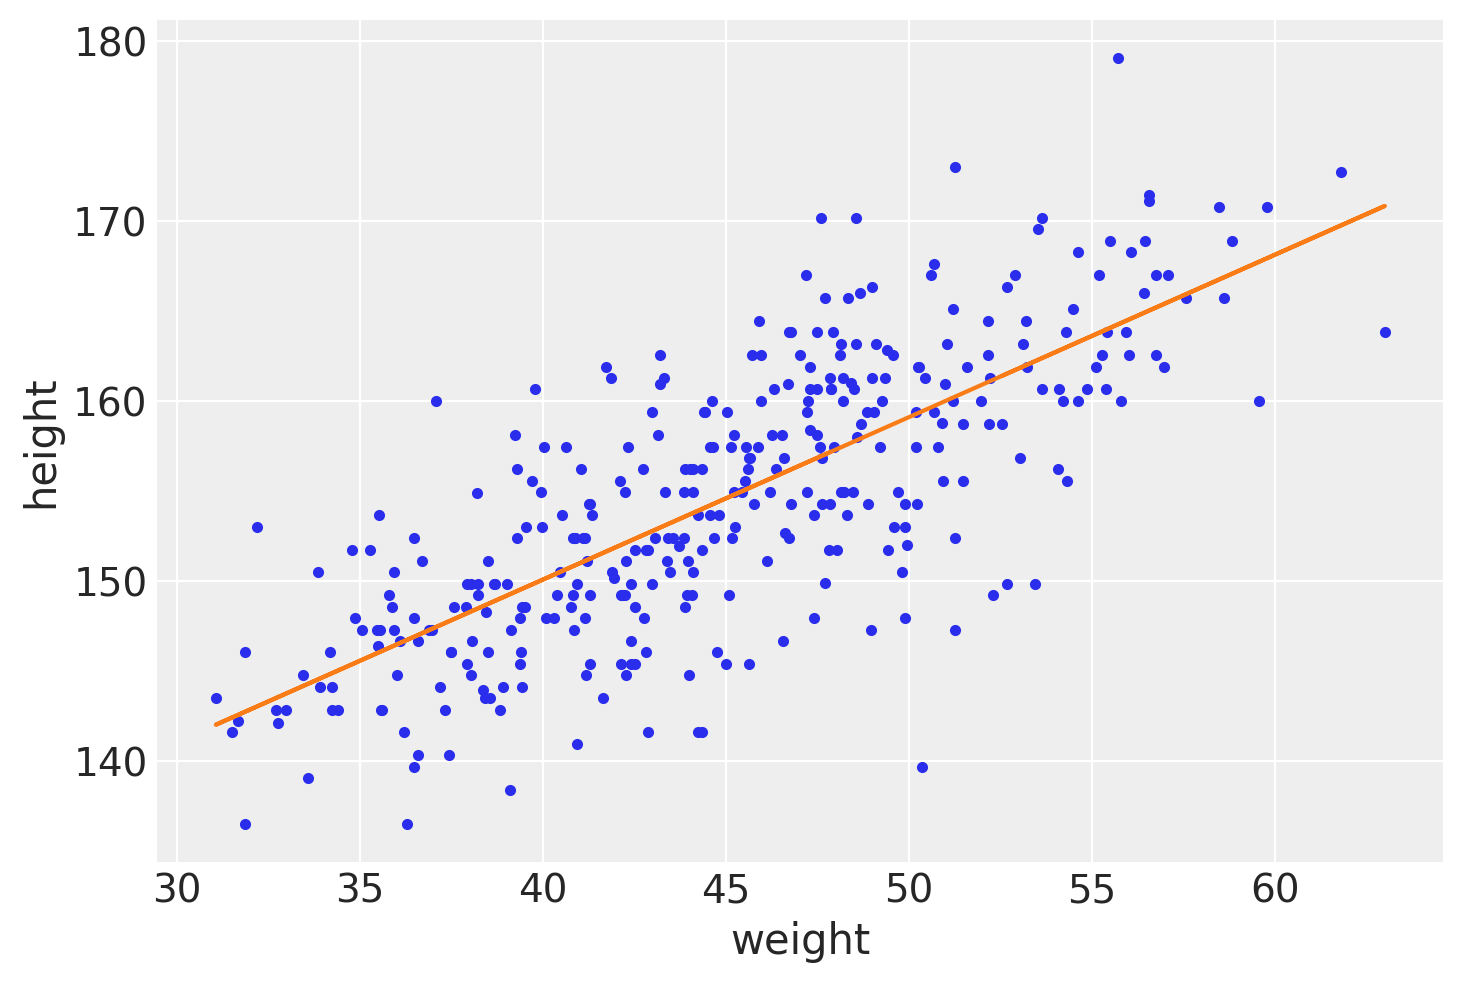

In [48]:
a = results_4_3_df["Intercept"].mean()
b = results_4_3_df["I(weight - xbar)"].mean()

plt.plot(d2.weight, d2.height, ".")
plt.plot(d2.weight, a + b * (d2.weight - xbar))
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

#### Code 4.47

In [49]:
results_4_3_df.head(5)

Intercept  I(weight - xbar)  height_sigma
chain draw                                            
0     0     154.686582          0.872226      4.984360
      1     154.954322          0.831385      4.974469
      2     154.245765          0.928724      4.736411
      3     154.329209          0.882361      5.313498
      4     154.900132          0.874990      4.879845

#### Code 4.48

In [50]:
N = 10
dN = d2[:N]

# We could do 
# 'height ~ I(weight - np.mean(weight))' 
# But the following does the same using transformations implemented in Bambi

priors = {
    'Intercept': bmb.Prior('Normal', mu=178, sd=20),         # a ~ dnorm(178 ,20)
    'center(weight)': bmb.Prior('Lognormal', mu=0, sigma=1), # b ~ dlnorm(0, 1)
    'height_sigma': bmb.Prior('Uniform', lower=0, upper=50)  # sigma ~ dunif(0, 50)
}
model_N = bmb.Model("height ~ center(weight)", dN, priors=priors)
results_N = model_N.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [height_sigma, center(weight), Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.


#### Code 4.49

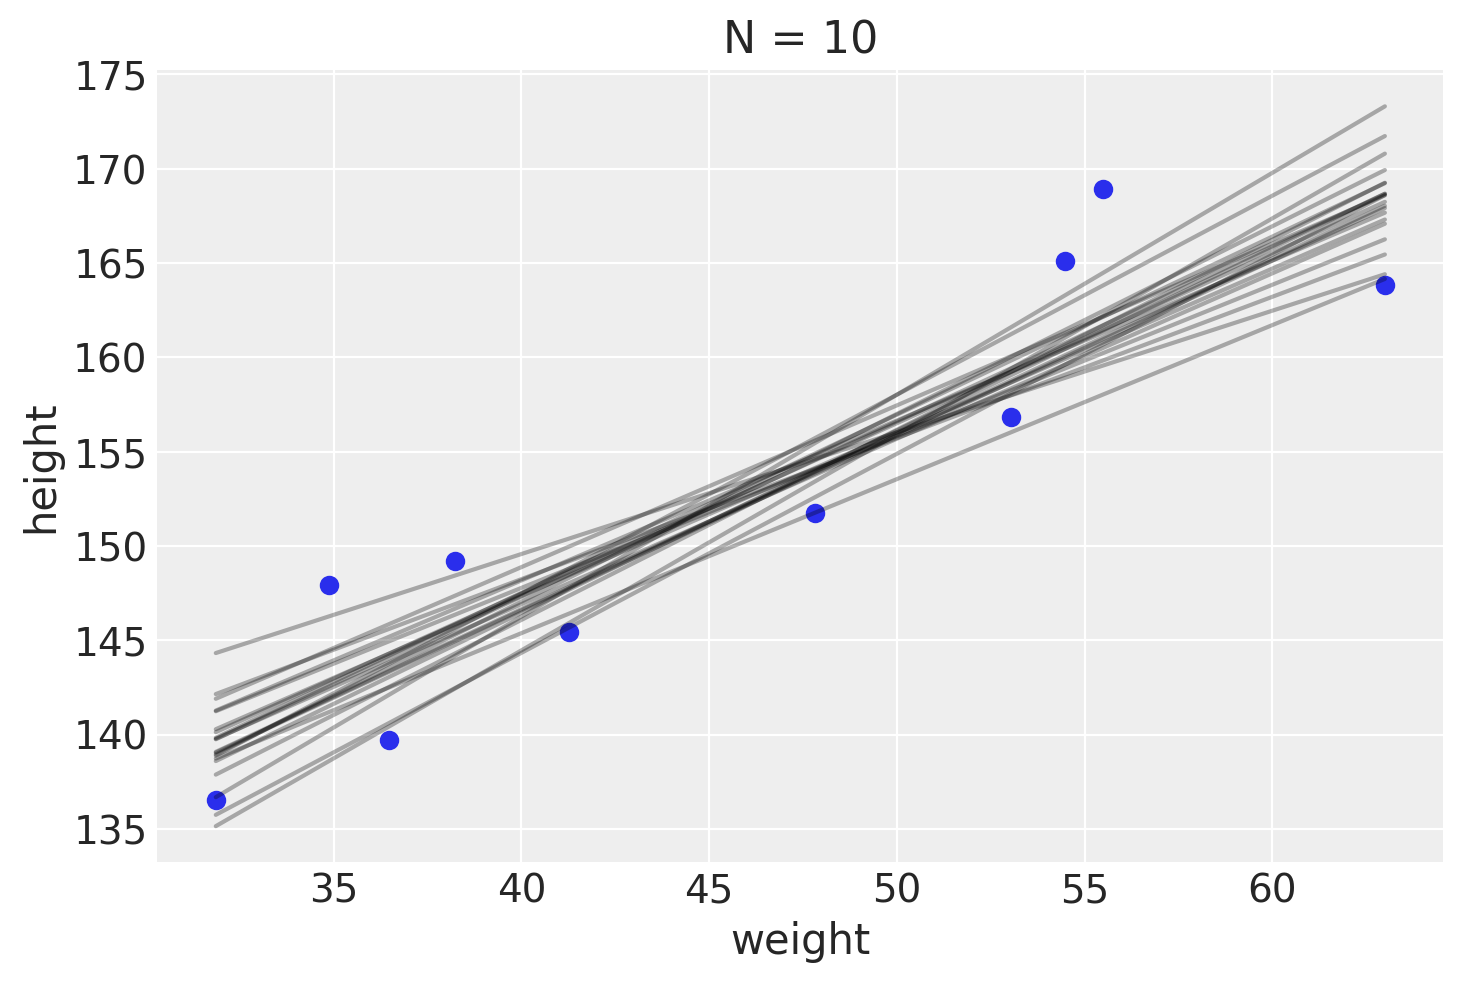

In [51]:
post = results_N.posterior.to_dataframe().head(20)
x = np.linspace(dN.weight.min(), dN.weight.max(), 20)
a = post["Intercept"].to_numpy()
b = post["center(weight)"].to_numpy()
xbar = dN.weight.mean()

plt.plot(dN.weight, dN.height, "o")
plt.title(f"N = {N}")
for i in range(len(post)):
    plt.plot(x, a[i] + b[i] * (x - xbar), color="black", alpha=0.3)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

#### Code 4.50

In [53]:
post = results_4_3_df
# Recompute xbar
xbar = d2.weight.mean()
mu_at_50 = post["Intercept"] + post["I(weight - xbar)"] * (50 - xbar)

#### Code 4.51

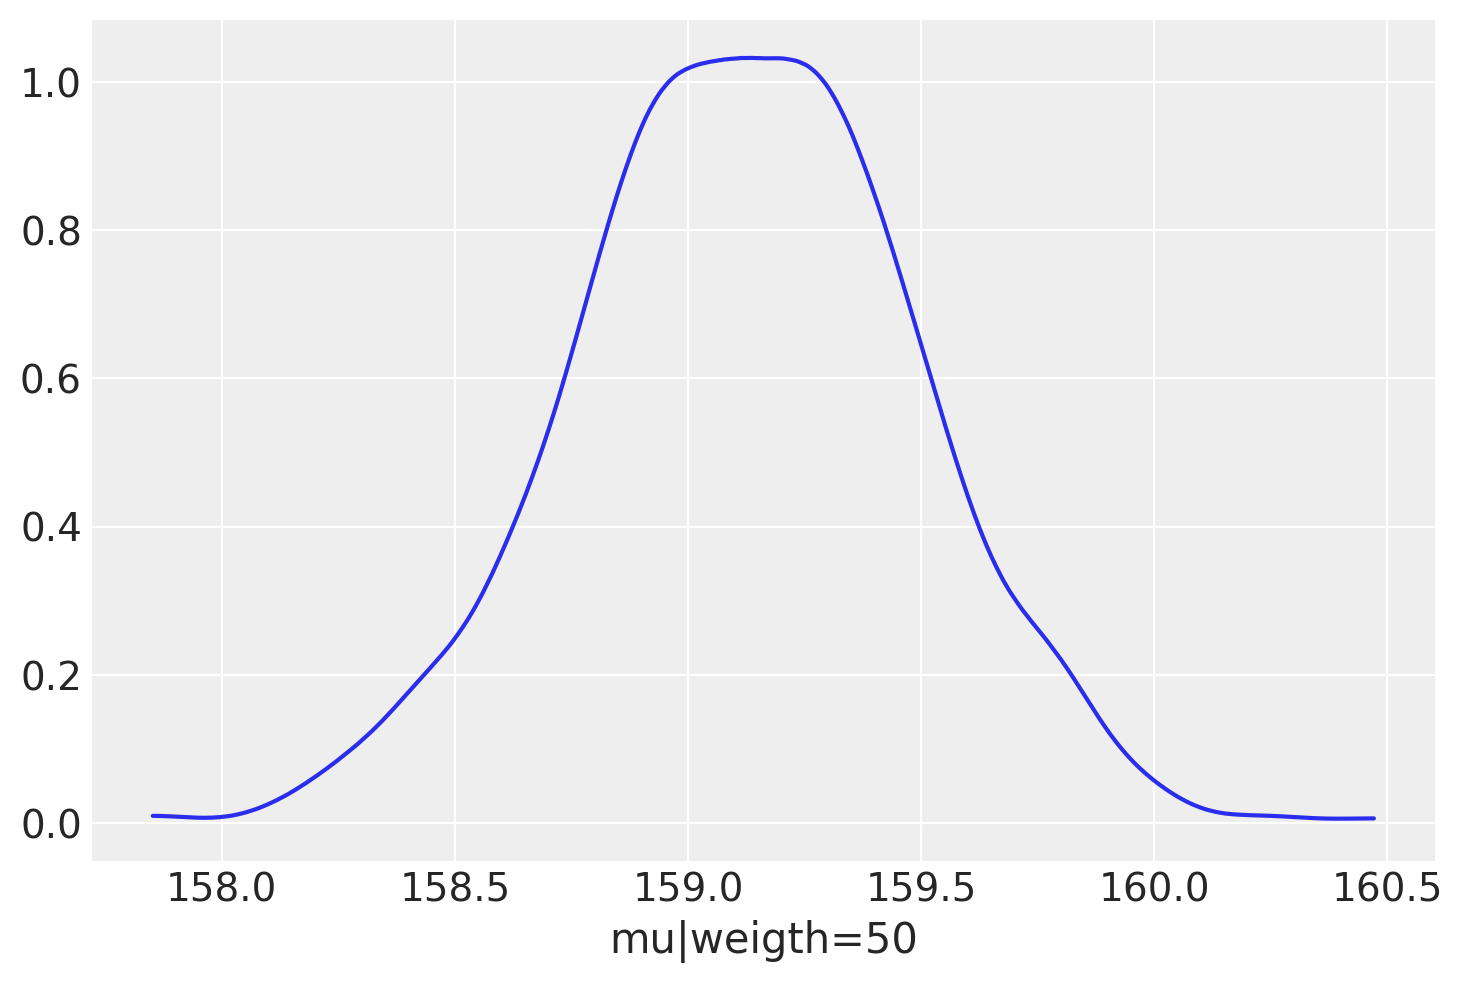

In [54]:
az.plot_kde(mu_at_50)
plt.xlabel("mu|weigth=50");

#### Code 4.52

In [55]:
np.quantile(mu_at_50, [0.05, 0.94])

array([158.50002848, 159.69341028])

#### Code 4.53 and 4.54

We have to manually compute mean for each case in the data and sample from the posterior because something like the `link()` function is not implemented in Bambi yet.

In [56]:
weight_seq = np.arange(25, 71)
a = results_4_3.posterior["Intercept"].values.flatten()
b = results_4_3.posterior["I(weight - xbar)"].values.flatten()
mu_pred = np.zeros((len(weight_seq), len(a)))

for i, w in enumerate(weight_seq):
    mu_pred[i] = a + b * (w - xbar)

#### Code 4.55

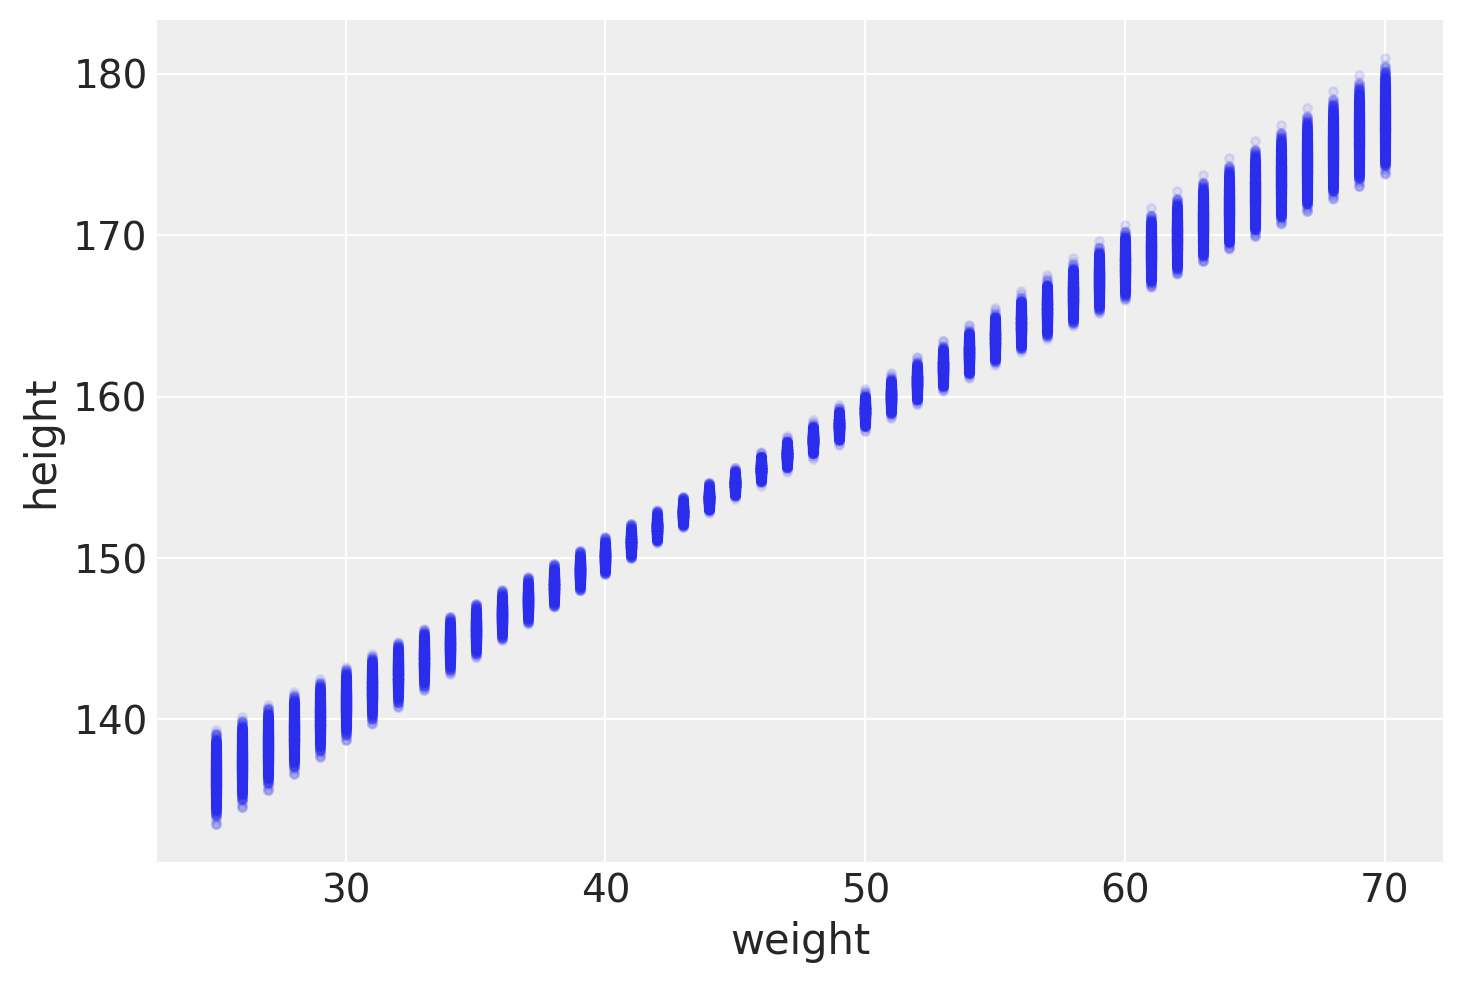

In [57]:
plt.plot(weight_seq, mu_pred, "C0.", alpha=0.1)
plt.xlabel("weight")
plt.ylabel("height");

#### Code 4.56

In [58]:
mu_mean = mu_pred.mean(1)
mu_PI = np.quantile(mu_pred, [0.05, 0.94], axis=1).T

#### Code 4.57

/home/tomas/anaconda3/envs/bmbrsrc/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


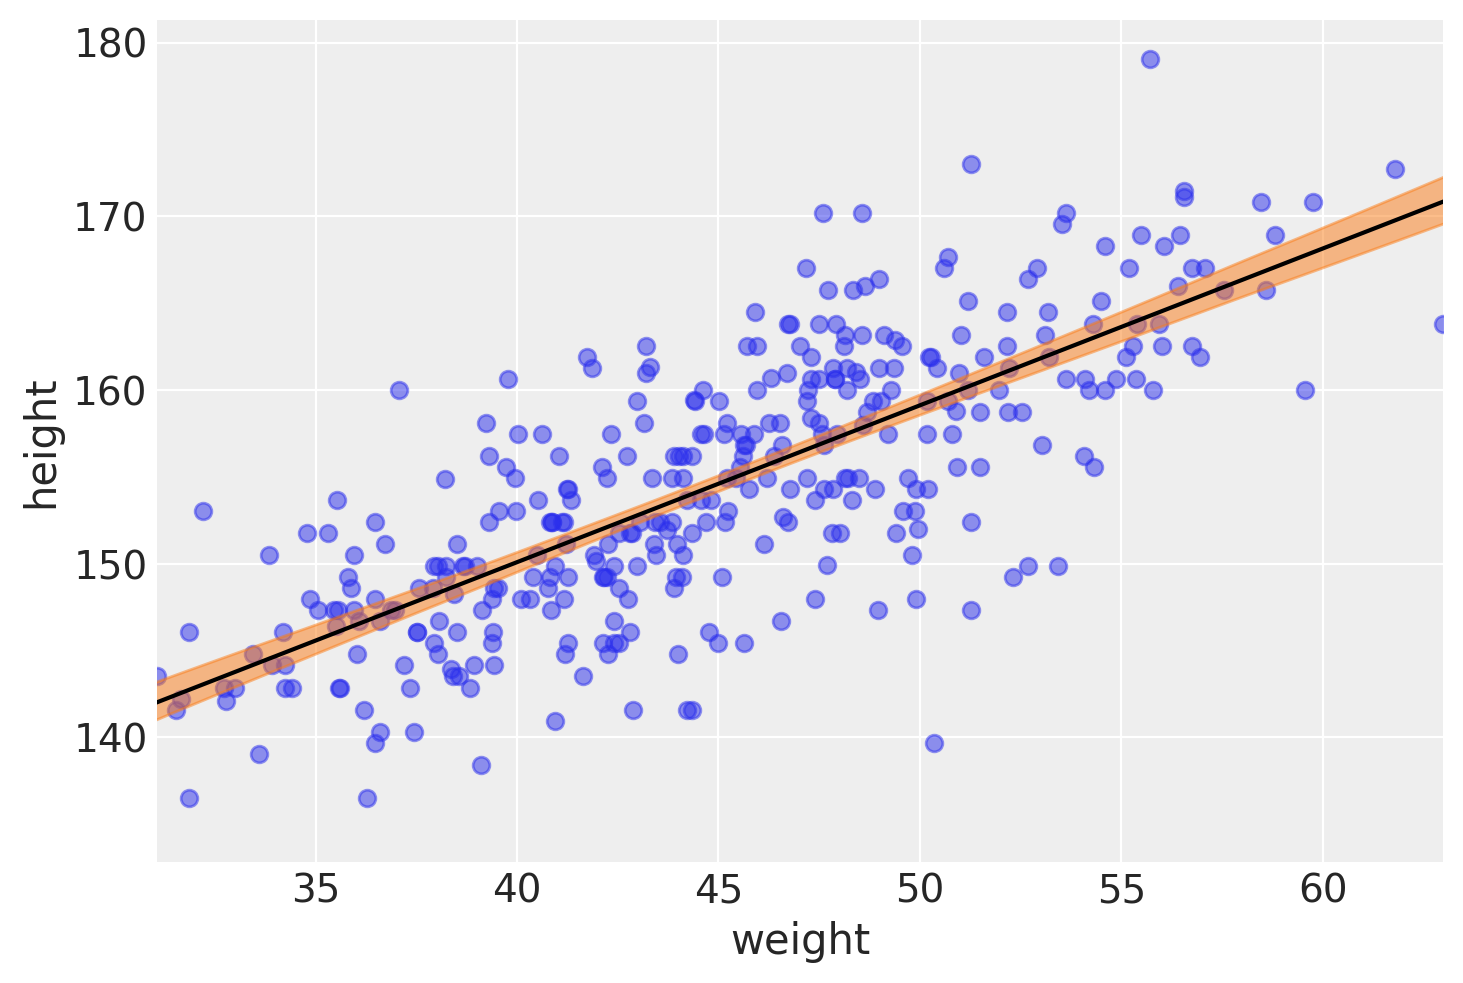

In [59]:
# plot raw data
# fading out points to make line and interval more visible
plt.scatter(d2.weight, d2.height, alpha=0.5)

# plot the MAP line, aka the mean mu for each weight
plt.plot(weight_seq, mu_mean, "k")

# plot a shaded region for 89% PI
az.plot_hdi(weight_seq, mu_pred.T, hdi_prob=0.89)

plt.xlabel("weight")
plt.ylabel("height");
plt.xlim(d2.weight.min(), d2.weight.max());

#### Code 4.58

#### Code 4.59

#### Code 4.60

#### Code 4.61

#### Code 4.62

#### Code 4.63

#### Code 4.64

#### Code 4.65

#### Code 4.66

#### Code 4.67

#### Code 4.68

#### Code 4.69

#### Code 4.70

#### Code 4.71

#### Code 4.72

#### Code 4.73

#### Code 4.74

#### Code 4.75